# IMPORTS

In [1]:
import os
import math
import time
import torch
import random
import warnings
import numpy as np
import pandas as pd
import torch.nn as nn
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, f1_score, classification_report
from accelerate import Accelerator, notebook_launcher
from torch.multiprocessing import Manager
from torch.utils.data import DataLoader, Dataset
from transformers import BertTokenizer, BertModel, BertPreTrainedModel, BertConfig, BertForSequenceClassification

# SETUP

In [2]:
warnings.filterwarnings('ignore')

In [3]:
if os.path.exists('/kaggle/working/results') == False:
    os.mkdir('/kaggle/working/results')

if os.path.exists('/kaggle/working/acquired_data') == False:
    os.mkdir('/kaggle/working/acquired_data')

In [4]:
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic=True
    torch.backends.cudnn.benchmark=False

set_seed(42)

# GLOBAL VARIABLES

In [5]:
manager = Manager()

# Shared resources
accuracies = manager.list()
f1_micros = manager.list()
f1_macros = manager.list()
data_used = manager.list()
sampling_dur = manager.list()
new_samples = manager.list()
farthest_point = manager.dict()

# Non shared resources
epochs = 10
batch_size = 32
sequence_length = 96

# LOAD AND PREPROCESS DATA

In [6]:
data = pd.read_csv('/kaggle/input/netifier-2/oversampled.csv', encoding='latin-1')
data.shape

(9800, 5)

In [7]:
data.head()

,processed_text,pornografi,sara,radikalisme,pencemaran_nama_baik
0,jabar memang provinsi barokah boleh juga dan n...,0,0,0,1
1,sidangahok semoga sipenista agama dan ateknya ...,0,1,1,1
2,itu membuktikan bahwa rakyat malaysia anti cin...,0,1,0,1
3,heh kontol jan sok pemes kamu di rp muka seper...,1,0,0,1
4,eh memek diam kamu kepala kamu kaya kontol muk...,1,0,0,0


In [8]:
train_data, val_data = train_test_split(data, test_size=0.2, random_state=42, shuffle=True)

In [9]:
train_labels = train_data.columns[1:]
val_labels = val_data.columns[1:]

# Extract features and labels for training and validation
X_train = train_data['processed_text'].values
y_train = train_data[train_labels].values
X_val = val_data['processed_text'].values
y_val = val_data[val_labels].values

print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)

(7840,) (7840, 4)
(1960,) (1960, 4)


# BUILD DATASET & DATALOADERS

In [10]:
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
from torch.utils.data import Dataset
import numpy as np
import torch

# Define custom Dataset class
class NetifierDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=96):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        labels = self.labels[idx]
        encoding = self.tokenizer(text, truncation=True, padding='max_length', max_length=self.max_length, return_tensors='pt')
        item = {key: val.squeeze() for key, val in encoding.items()}
        item['labels'] = torch.tensor(labels, dtype=torch.float)
        return item

# Initialize BERT tokenizer and model
tokenizer = BertTokenizer.from_pretrained('indobenchmark/indobert-base-p1')

tokenizer_config.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/229k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.53k [00:00<?, ?B/s]

In [11]:
def get_dataloaders(X_train, y_train, X_val, y_val, sequence_length=96, num_workers=4):
    train_dataset = NetifierDataset(X_train, y_train, tokenizer, max_length=sequence_length)
    val_dataset = NetifierDataset(X_val, y_val, tokenizer, max_length=sequence_length)
    train_loader = torch.utils.data.DataLoader(
        train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True, num_workers=num_workers
    )
    val_loader = torch.utils.data.DataLoader(
        val_dataset, batch_size=batch_size, shuffle=False, pin_memory=True, num_workers=num_workers
    )

    return train_loader, val_loader

# TRAIN THE MODEL

In [12]:
total_data = len(X_train) + len(X_val)
initial_train_size = int(0.05 * total_data)
checkpoints = [
    int(0.5 * total_data), 
    int(0.6 * total_data), 
    int(0.7 * total_data),
    len(X_train)
]
min_increment = 200

In [13]:
def compute_metrics(p):
    preds = torch.tensor(p.predictions) # Sigmoid and threshold for multi-label
    labels = torch.tensor(p.label_ids)

    # Hamming accuracy: proportion of correctly predicted labels over total labels
    accuracy = (preds == labels).float().mean().item()

    # Standard multi-label precision, recall, and F1 metrics
    precision, recall, f1_micro, _ = precision_recall_fscore_support(labels, preds, average='micro', zero_division=0)
    _, _, f1_macro, _ = precision_recall_fscore_support(labels, preds, average='macro', zero_division=0)

    report = classification_report(
        labels, 
        preds, 
        target_names=['pornografi', 'sara', 'radikalisme', 'pencemaran_nama_baik'],
        zero_division=0
    ) 

    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_micro': f1_micro,
        'f1_macro': f1_macro,
        'report': report
    }

In [14]:
def train_model(current_train_size, train_indices, metrics, trials, seed, filename):
    accelerator = Accelerator(mixed_precision='fp16')
    device = accelerator.device
    accelerator.print(accelerator.distributed_type)

    with accelerator.main_process_first():
        model = BertForSequenceClassification.from_pretrained(
            'indobenchmark/indobert-base-p1',
            num_labels=len(train_labels),
            problem_type="multi_label_classification"
        )

    # Freeze the first few layers of the encoder
    for name, param in model.named_parameters():
        if "encoder.layer" in name:
            layer_num = name.split(".")[3]
            try:
                if int(layer_num) < 6:
                    param.requires_grad = False
            except ValueError:
                continue

    # Define DataLoaders
    current_X_train = [X_train[i] for i in train_indices]
    current_y_train = [y_train[i] for i in train_indices]
    train_loader, val_loader = get_dataloaders(current_X_train, current_y_train, X_val, y_val)

    # Define optimizer and loss function
    optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5, weight_decay=0.01)
    loss_fn = torch.nn.BCEWithLogitsLoss()

    # Prepare everything with Accelerator
    model, optimizer, train_loader, val_loader = accelerator.prepare(
        model, optimizer, train_loader, val_loader
    )

    best_result = None
    start_time = time.time()

    for epoch in range(epochs):
        model.train()
        epoch_loss = 0

        for batch in train_loader:
            inputs = {key: val for key, val in batch.items() if key != 'labels'}
            labels = batch['labels']

            optimizer.zero_grad()
            outputs = model(**inputs)
            loss = loss_fn(outputs.logits, labels)
            accelerator.backward(loss)
            optimizer.step()

            epoch_loss += loss.item()

        # Evaluation
        model.eval()
        all_preds = []
        all_labels = []
        
        with torch.no_grad():
            for batch in val_loader:
                inputs = {key: val for key, val in batch.items() if key != 'labels'}
                labels = batch['labels']
                
                outputs = model(**inputs)
                preds = torch.sigmoid(outputs.logits).round()

                # Gather predictions and labels from all devices
                all_preds.append(accelerator.gather(preds))
                all_labels.append(accelerator.gather(labels))

        all_preds = torch.cat(all_preds).cpu().numpy()
        all_labels = torch.cat(all_labels).cpu().numpy()

        result = compute_metrics(type('EvalOutput', (object,), {'predictions': all_preds, 'label_ids': all_labels}))

        if best_result is None or result['f1_micro'] >= best_result['f1_micro']:
            accelerator.print("Higher F1 achieved, saving model")

            nearest_cp = current_train_size
            if nearest_cp not in checkpoints:
                for cp in checkpoints:
                    if cp > current_train_size:
                        nearest_cp = cp
                        break
            percentage = math.ceil(nearest_cp / total_data * 100)
            
            accelerator.wait_for_everyone()
            unwrapped_model = accelerator.unwrap_model(model)
            unwrapped_model.save_pretrained(
                f'{filename}-{trials + 1}-model-{percentage}',
                is_main_process=accelerator.is_main_process,
                save_function=accelerator.save,
            )
            best_result = result

        accelerator.print(f"Epoch {epoch + 1}/{epochs}, Train Loss: {round(epoch_loss / len(train_loader), 4)}, Accuracy: {round(result['accuracy'], 4)}, F1 Micro: {round(result['f1_micro'], 4)}, F1 Macro: {round(result['f1_macro'], 4)}")

    end_time = time.time()
    duration = end_time - start_time
    
    accelerator.print(f"\n Iteration {current_train_size}: Accuracy: {round(best_result['accuracy'], 4)}, F1 Micro: {round(best_result['f1_micro'], 4)}, F1 Macro: {round(best_result['f1_macro'], 4)}")
    accelerator.print(best_result['report'])
    accelerator.print(f"Training completed in {duration} s")

    # Update the shared lists
    if accelerator.is_local_main_process:
        metrics[0].append(current_train_size)
        metrics[1].append(best_result['accuracy'])
        metrics[2].append(best_result['f1_micro'])
        metrics[3].append(best_result['f1_macro'])

# PLOT THE RESULTS

In [15]:
import matplotlib.pyplot as plt

def plot_result(data_used, accuracies, f1_micros, f1_macros):
    fig, axs = plt.subplots(1, 3, figsize=(21, 5))
    data_used = [round(data / total_data * 100, 1) for data in data_used]

    # Plot for Accuracy
    axs[0].plot(data_used, accuracies, label="Accuracy", color="blue")
    axs[0].set_xlabel("Percentage of data used")
    axs[0].set_title("Accuracy")
    axs[0].set_xticks(data_used)

    # Plot for F1 Micro
    axs[1].plot(data_used, f1_micros, label="F1 Micro", color="orange")
    axs[1].set_xlabel("Percentage of data used")
    axs[1].set_title("F1 Micro")
    axs[1].set_xticks(data_used)

    # Plot for F1 Macro
    axs[2].plot(data_used, f1_macros, label="F1 Macro", color="green")
    axs[2].set_xlabel("Percentage of data used")
    axs[2].set_title("F1 Macro")
    axs[2].set_xticks(data_used)

    # Adjust layout and show the plots
    plt.tight_layout()
    plt.show()

# QUERY STRATEGY

In [16]:
def least_confidence_sampling(model, X_pool, train_indices, remaining_indices, sampling_dur, new_samples, trials, filename, n_samples=min_increment):
    accelerator = Accelerator(mixed_precision="fp16")
    device = accelerator.device

    model.to(device)

    current_train_size = len(train_indices)
    dataset = NetifierDataset(X_pool, np.zeros((len(X_pool), 4)), tokenizer, max_length=sequence_length)
    dataloader = DataLoader(
        dataset,
        batch_size=batch_size,
        num_workers=4,
        pin_memory=True,
    )
    
    model.eval()
    start_time = time.time()
    
    uncertainties = []
    for data in dataloader:
        input_ids = data['input_ids'].to(device, non_blocking=True)
        attention_mask = data['attention_mask'].to(device, non_blocking=True)
        with torch.no_grad():
            outputs = model(input_ids=input_ids, attention_mask=attention_mask).logits

        for output in outputs:
            probs = torch.sigmoid(output).cpu().numpy()
            uncertainty = np.absolute(1 - np.max(probs))
            uncertainties.append(uncertainty)
    
    uncertainties = np.array(uncertainties)
    sorted_unc = np.argsort(uncertainties)
    sorted_unc = sorted_unc[::-1]

    accelerator.wait_for_everyone()

    if accelerator.is_local_main_process:
        threshold = np.percentile(uncertainties, 90)
        items_greater_than_average = uncertainties[uncertainties >= threshold]
        num_of_candidates = len(items_greater_than_average)
    
        # Check nearest checkpoint
        nearest_cp = 0
        for cp in checkpoints:
            if cp > current_train_size:
                nearest_cp = cp
                break
        
        if num_of_candidates <= n_samples and n_samples < nearest_cp - current_train_size:
            least_confident_indices = sorted_unc[:n_samples]
        elif num_of_candidates > n_samples and num_of_candidates < nearest_cp - current_train_size:
             least_confident_indices = sorted_unc[:max(n_samples, min(math.ceil(0.1*len(sorted_unc)), num_of_candidates))]
        else:
            least_confident_indices = sorted_unc[:nearest_cp - current_train_size]
    
            temp = train_indices.copy()
            temp.extend([remaining_indices[i] for i in least_confident_indices])
            
            # Save acquired data up to checkpoint
            acquired_data = pd.DataFrame({
                'processed_text': [X_train[i] for i in temp],
                'pornografi': [y_train[i][0] for i in temp],
                'sara': [y_train[i][1] for i in temp],
                'radikalisme': [y_train[i][2] for i in temp],
                'pencemaran_nama_baik': [y_train[i][3] for i in temp],
            })
    
            acquired_data.to_csv(f'acquired_data/{filename}-{trials+1}-data-{nearest_cp}.csv', index=False)
    
        end_time = time.time() 
        duration = end_time - start_time
    
        sampling_dur.append(duration)
        for i in least_confident_indices:
            new_samples.append(remaining_indices[i])
            
        print("Nearest checkpoint:", nearest_cp)
        print("Threshold:", threshold)
        print("Samples above threshold:", num_of_candidates)
        print("Acquired samples:", len(least_confident_indices))
        print(f"Sampling duration: {duration} seconds")

In [17]:
def monte_carlo_dropout_sampling(model, X_pool, train_indices, remaining_indices, sampling_dur, new_samples, trials, filename, mc_passes=3, n_samples=min_increment):
    accelerator = Accelerator(mixed_precision="fp16")
    device = accelerator.device

    model.to(device)

    current_train_size = len(train_indices)
    dataset = NetifierDataset(X_pool, np.zeros((len(X_pool), 4)), tokenizer, max_length=sequence_length)
    dataloader = DataLoader(
        dataset,
        batch_size=batch_size,
        num_workers=4,
        pin_memory=True,
    )
    
    model.train()
    start_time = time.time()

    confidences = []
    for data in dataloader:
        # Collect multiple predictions to calculate uncertainty
        batch_probs = []
        input_ids = data['input_ids'].to(device)
        attention_mask = data['attention_mask'].to(device)

        for _ in range(mc_passes):
            with torch.no_grad():
                outputs = model(input_ids=input_ids, attention_mask=attention_mask).logits
            probs = torch.sigmoid(outputs).cpu().numpy()  # Shape: (batch_size, num_classes)
            batch_probs.append(probs)

        # Stack the probabilities from multiple MC passes
        batch_probs = np.stack(batch_probs, axis=0)  # Shape: (mc_passes, batch_size, num_classes)

        # Calculate mean probability and uncertainty for each sample in the batch
        mean_probs = np.mean(batch_probs, axis=0)  # Shape: (batch_size, num_classes)
        uncertainties = np.mean(np.var(batch_probs, axis=0), axis=1)  # Shape: (batch_size,)

        # Append the uncertainties to the confidences list
        confidences.extend(uncertainties)
    
    uncertainties = np.array(confidences)
    sorted_unc = np.argsort(confidences)
    sorted_unc = sorted_unc[::-1]

    accelerator.wait_for_everyone()

    if accelerator.is_local_main_process:
        threshold = np.percentile(confidences, 90)
        items_greater_than_average = uncertainties[confidences >= threshold]
        num_of_candidates = len(items_greater_than_average)
    
        # Check nearest checkpoint
        nearest_cp = 0
        for cp in checkpoints:
            if cp > current_train_size:
                nearest_cp = cp
                break
        
        if num_of_candidates <= n_samples and n_samples < nearest_cp - current_train_size:
            most_uncertain_indices = sorted_unc[:n_samples]
        elif num_of_candidates > n_samples and num_of_candidates < nearest_cp - current_train_size:
            most_uncertain_indices = sorted_unc[:max(n_samples, min(math.ceil(0.1*len(sorted_unc)), num_of_candidates))]
        else:
            most_uncertain_indices = sorted_unc[:nearest_cp - current_train_size]
    
            temp = train_indices.copy()
            temp.extend([remaining_indices[i] for i in most_uncertain_indices])
            
            # Save acquired data up to checkpoint
            acquired_data = pd.DataFrame({
                'processed_text': [X_train[i] for i in temp],
                'pornografi': [y_train[i][0] for i in temp],
                'sara': [y_train[i][1] for i in temp],
                'radikalisme': [y_train[i][2] for i in temp],
                'pencemaran_nama_baik': [y_train[i][3] for i in temp],
            })
    
            acquired_data.to_csv(f'acquired_data/{filename}-{trials+1}-data-{nearest_cp}.csv', index=False)
    
        end_time = time.time() 
        duration = end_time - start_time
    
        sampling_dur.append(duration)
        for i in most_uncertain_indices:
            new_samples.append(remaining_indices[i])
            
        print("Nearest checkpoint:", nearest_cp)
        print("Threshold:", threshold)
        print("Samples above threshold:", num_of_candidates)
        print("Acquired samples:", len(most_uncertain_indices))
        print(f"Sampling duration: {duration} seconds")

In [18]:
def kmeans_clustering_sampling(model, X_pool, train_indices, remaining_indices, tokenizer, sampling_dur, new_samples, trials, filename, n_clusters=min_increment):
    accelerator = Accelerator(mixed_precision="fp16")
    device = accelerator.device

    model.to(device)

    current_train_size = len(train_indices)
    dataset = NetifierDataset(X_pool, np.zeros((len(X_pool), 4)), tokenizer, max_length=sequence_length)
    dataloader = DataLoader(
        dataset,
        batch_size=batch_size,
        num_workers=4,
        pin_memory=True,
    )

    model.eval()
    start_time = time.time()
    embeddings = []
    
    with torch.no_grad():
        for data in dataloader:
            input_ids = data['input_ids'].to(device)
            attention_mask = data['attention_mask'].to(device)
            outputs = model.base_model(input_ids=input_ids, attention_mask=attention_mask)
            hidden_states = outputs.last_hidden_state.mean(dim=1)  # Mean of hidden states for vector representation
            embeddings.append(hidden_states.cpu().numpy())
    
    # Convert embeddings list to numpy array
    embeddings = np.vstack(embeddings)
    embeddings = np.array(embeddings)
    
    collected_indices = set()  # Initialize set to store selected indices
    thresholds = []

    accelerator.wait_for_everyone()

    if accelerator.is_local_main_process:
        target_samples = len(embeddings[:math.ceil(0.1 * len(embeddings))])
    
        # Check nearest checkpoint
        nearest_cp = 0
        arrived_at_cp = False
        for cp in checkpoints:
            if cp > current_train_size:
                nearest_cp = cp
                break
                
        # Determine number of maximum samples to be acquired
        if target_samples <= n_clusters and n_clusters < nearest_cp - current_train_size:
            target_samples = n_clusters
        elif target_samples > n_clusters and target_samples < nearest_cp - current_train_size:
            target_samples = target_samples
        else:
            arrived_at_cp = True
            target_samples = nearest_cp - current_train_size

        # No clustering needed when there's little data left
        if current_train_size >= checkpoints[len(checkpoints)-1] - min_increment:
            end_time = time.time()
            duration = end_time - start_time
            
            temp = train_indices.copy()
            temp.extend(remaining_indices)
            
            # Save acquired data up to checkpoint
            acquired_data = pd.DataFrame({
                'processed_text': [X_train[i] for i in temp],
                'pornografi': [y_train[i][0] for i in temp],
                'sara': [y_train[i][1] for i in temp],
                'radikalisme': [y_train[i][2] for i in temp],
                'pencemaran_nama_baik': [y_train[i][3] for i in temp],
            })
            acquired_data.to_csv(f'acquired_data/{filename}-{trials+1}-data-{nearest_cp}.csv', index=False)

            print("Nearest checkpoint:", nearest_cp)
            print("Acquired samples:", len(remaining_indices))
            print(f"Sampling duration: {duration} seconds")
            
            sampling_dur.append(duration)
            for i in remaining_indices:
                new_samples.append(i)
        else:
            # Cluster the data based on its embeddings
            kmeans=KMeans(n_clusters=n_clusters, n_init=1)
            kmeans.fit(embeddings)
            
            for cluster_id in range(n_clusters):
                # Cluster center and indices of samples in the current cluster
                cluster_center = kmeans.cluster_centers_[cluster_id]
                cluster_indices = np.where(kmeans.labels_ == cluster_id)[0]
            
                if cluster_indices.size == 0:
                    # Skip clusters with no members
                    print(f"Cluster {cluster_id} has no members, skipping.")
                    continue
            
                # Calculate distances of each point in the cluster from the cluster center
                cluster_distances = np.linalg.norm(embeddings[cluster_indices] - cluster_center, axis=1)
            
                # Determine the local threshold (10th percentile of closest distances to cluster center)
                local_threshold = np.percentile(cluster_distances, 90)
                thresholds.append(local_threshold)
            
                below_threshold_indices = cluster_indices[cluster_distances >= local_threshold]
                collected_indices.update(below_threshold_indices)

            # To handle multiple points with same distance
            if len(collected_indices) > target_samples:
                collected_indices = np.array(list(collected_indices))
                np.random.shuffle(collected_indices)
                collected_indices = collected_indices[:target_samples]
                
            end_time = time.time() 
            duration = end_time - start_time 
    
            if arrived_at_cp:
                temp = train_indices.copy()
                temp.extend(collected_indices)
                
                # Save acquired data up to checkpoint
                acquired_data = pd.DataFrame({
                    'processed_text': [X_train[i] for i in temp],
                    'pornografi': [y_train[i][0] for i in temp],
                    'sara': [y_train[i][1] for i in temp],
                    'radikalisme': [y_train[i][2] for i in temp],
                    'pencemaran_nama_baik': [y_train[i][3] for i in temp],
                })
        
                acquired_data.to_csv(f'acquired_data/{filename}-{trials+1}-data-{nearest_cp}.csv', index=False)
            
            print("Nearest checkpoint:", nearest_cp)
            # print(f"Thresholds: {thresholds}")
            print("Acquired samples:", len(collected_indices))
            print(f"Sampling duration: {duration} seconds")
        
            sampling_dur.append(duration)
            for i in collected_indices:
                new_samples.append(remaining_indices[i])

        threshold_data = pd.DataFrame({
            'Threshold': thresholds
        })
        threshold_data.to_csv(f"results/{filename}-thresholds-{trials+1}-{current_train_size}.csv", index=False)

In [19]:
def coreset_sampling(model, farthest_point, X_pool, train_indices, remaining_indices, sampling_dur, new_samples, trials, filename, n_samples=min_increment):
    accelerator = Accelerator(mixed_precision="fp16")
    device = accelerator.device
    model.to(device)

    current_train_size = len(train_indices)
    dataset = NetifierDataset(X_pool, np.zeros((len(X_pool), 4)), tokenizer, max_length=sequence_length)
    dataloader = DataLoader(
        dataset,
        batch_size=batch_size,
        num_workers=4,
        pin_memory=True,
        shuffle=False,
    )
    farthest_data = dict(farthest_point)
    
    model.eval()
    start_time = time.time()
    embeddings = []
    
    for data in dataloader:
        input_ids = data['input_ids'].to(device, non_blocking=True)
        attention_mask = data['attention_mask'].to(device, non_blocking=True)
        with torch.no_grad():
            outputs = model.base_model(input_ids=input_ids, attention_mask=attention_mask)

        hidden_states = outputs.last_hidden_state.mean(dim=1)  # Mean of hidden states for vector representation
        embeddings.append(hidden_states.cpu().numpy())

    if 'input_ids' in farthest_data:
        with torch.no_grad():
            outputs = model.base_model(
                input_ids=farthest_data['input_ids'].unsqueeze(0).to(device, non_blocking=True), 
                attention_mask=farthest_data['attention_mask'].unsqueeze(0).to(device, non_blocking=True)
            )
            hidden_states = outputs.last_hidden_state.mean(dim=1)  # Mean of hidden states for vector representation
            embeddings.append(hidden_states.cpu().numpy())
    
    embeddings = np.vstack(embeddings)
    embeddings = np.array(embeddings)

    accelerator.wait_for_everyone()

    if accelerator.is_local_main_process:
        # Use pairwise distances to compute a distance matrix for Coreset selection
        distance_matrix = pairwise_distances(embeddings)    
        selected_indices = distance_matrix.shape[0] - 1 if 'input_ids' in farthest_data else 0
        
        # Calculate the minimum distance from selected points to all other points
        min_distances = distance_matrix[selected_indices]

        sorted_dist = np.argsort(min_distances)
        sorted_dist = sorted_dist[::-1]
        farthest_point['input_ids'] = dataset[sorted_dist[0]]['input_ids']
        farthest_point['attention_mask'] = dataset[sorted_dist[0]]['attention_mask']
                
        threshold = np.percentile(min_distances, 90)
        candidates = np.where(min_distances >= threshold)[0]  # Select the point farthest from the current set
        num_of_candidates = len(candidates)
    
        # Check nearest checkpoint
        nearest_cp = 0
        for cp in checkpoints:
            if cp > current_train_size:
                nearest_cp = cp
                break
        
        if num_of_candidates <= n_samples and n_samples < nearest_cp - current_train_size:
            selected_indices = sorted_dist[:n_samples]
        elif num_of_candidates > n_samples and num_of_candidates < nearest_cp - current_train_size:
             selected_indices = sorted_dist[:max(n_samples, min(math.ceil(0.1*len(sorted_dist)), num_of_candidates))]
        else:
            selected_indices = sorted_dist[:nearest_cp - current_train_size]
    
            temp = train_indices.copy()
            temp.extend([remaining_indices[i] for i in selected_indices])
            
            # Save acquired data up to checkpoint
            acquired_data = pd.DataFrame({
                'processed_text': [X_train[i] for i in temp],
                'pornografi': [y_train[i][0] for i in temp],
                'sara': [y_train[i][1] for i in temp],
                'radikalisme': [y_train[i][2] for i in temp],
                'pencemaran_nama_baik': [y_train[i][3] for i in temp],
            })
    
            acquired_data.to_csv(f'acquired_data/{filename}-{trials+1}-data-{nearest_cp}.csv', index=False)
    
        end_time = time.time() 
        duration = end_time - start_time
    
        sampling_dur.append(duration)
        for i in selected_indices:
            new_samples.append(remaining_indices[i])
            
        print("Nearest checkpoint:", nearest_cp)
        print("Threshold:", threshold)
        print("Samples above threshold:", num_of_candidates)
        print("Acquired samples:", len(selected_indices))
        print(f"Sampling duration: {duration} seconds")

In [20]:
def random_sampling(current_train_size, X_pool, train_indices, remaining_indices, sampling_dur, new_samples, trials, filename, n_samples=min_increment):
    start_time = time.time()
    
    nearest_cp = 0
    arrived_at_cp = False
    for cp in checkpoints:
        if cp > current_train_size:
            nearest_cp = cp
            break

    num_of_candidates = math.ceil(0.1 * len(remaining_indices))

    if num_of_candidates <= n_samples and n_samples < nearest_cp - current_train_size:
        num_of_candidates = n_samples
    elif num_of_candidates > n_samples and num_of_candidates < nearest_cp - current_train_size:
        num_of_candidates = max(n_samples, num_of_candidates)
    else:
        num_of_candidates = nearest_cp - current_train_size
        arrived_at_cp = True

    random_indices = random.sample(range(len(X_pool)), num_of_candidates)

    if arrived_at_cp:
        temp = train_indices.copy()
        temp.extend([remaining_indices[i] for i in random_indices])
            
        # Save acquired data up to checkpoint
        acquired_data = pd.DataFrame({
            'processed_text': [X_train[i] for i in temp],
            'pornografi': [y_train[i][0] for i in temp],
            'sara': [y_train[i][1] for i in temp],
            'radikalisme': [y_train[i][2] for i in temp],
            'pencemaran_nama_baik': [y_train[i][3] for i in temp],
        })

        acquired_data.to_csv(f'acquired_data/{filename}-{trials+1}-data-{nearest_cp}.csv', index=False)

    end_time = time.time() 
    duration = end_time - start_time

    sampling_dur.append(duration)
    for i in random_indices:
        new_samples.append(remaining_indices[i])
        
    print("Nearest checkpoint:", nearest_cp)
    print("Acquired samples:", len(random_indices))
    print(f"Sampling duration: {duration} seconds")

# MAIN LOOP

In [ ]:
def active_learning(seed, i, sampling_strategy):
    accuracies = manager.list()
    f1_micros = manager.list()
    f1_macros = manager.list()
    data_used = manager.list()
    sampling_dur = manager.list()
    new_samples = manager.list()
    farthest_point = manager.dict()
    filename = f'netifier-oversampled-{sampling_strategy}'

    set_seed(seed)
    
    print("===============================================")
    print("TRIAL {}".format(i+1))
    print("Random seed:", seed)
    
    train_indices = np.random.choice(range(len(X_train)), initial_train_size, replace=False).tolist()
    remaining_indices = list(set(range(len(X_train))) - set(train_indices))
    
    current_train_size = initial_train_size
    
    start_time = time.time()
    while current_train_size < checkpoints[len(checkpoints) - 1]:
        # Train the model
        args = (current_train_size, train_indices, (data_used, accuracies, f1_micros, f1_macros), i, seed, filename)
        notebook_launcher(train_model, args, num_processes=2)

        nearest_cp = current_train_size
        if nearest_cp not in checkpoints:
            for cp in checkpoints:
                if cp > current_train_size:
                    nearest_cp = cp
                    break
        percentage = math.ceil(nearest_cp / total_data * 100)
        
        model = BertForSequenceClassification.from_pretrained(f'{filename}-{i + 1}-model-{percentage}')
    
        # Perform query strategy to select new samples
        new_samples = manager.list()
        if sampling_strategy == 'lc':
            print("LC")
            sampling_args = (model, [X_train[i] for i in remaining_indices], train_indices, remaining_indices, sampling_dur, new_samples, i, filename)
            notebook_launcher(least_confidence_sampling, sampling_args, num_processes=2)
        elif sampling_strategy == 'mc':
            print("MC")
            sampling_args = (model, [X_train[i] for i in remaining_indices], train_indices, remaining_indices, sampling_dur, new_samples, i, filename)
            notebook_launcher(monte_carlo_dropout_sampling, sampling_args, num_processes=2)
        elif sampling_strategy == 'kmeans':
            print("KMeans")
            sampling_args = (model, [X_train[i] for i in remaining_indices], train_indices, remaining_indices, tokenizer, sampling_dur, new_samples, i, filename)
            notebook_launcher(kmeans_clustering_sampling, sampling_args, num_processes=2)
        elif sampling_strategy == 'coreset':
            print("Coreset")
            sampling_args = (model, farthest_point, [X_train[i] for i in remaining_indices], train_indices, remaining_indices, sampling_dur, new_samples, i, filename)
            notebook_launcher(coreset_sampling, sampling_args, num_processes=2)
        elif sampling_strategy == 'random':
            print("Random")
            random_sampling(current_train_size, [X_train[i] for i in remaining_indices], train_indices, remaining_indices, sampling_dur, new_samples, i, filename)

        new_samples = list(new_samples)
        train_indices.extend(new_samples)
        remaining_indices = list(set(remaining_indices) - set(new_samples))
    
        # Update current training size
        current_train_size = len(train_indices)
        print("New train size: {}".format(current_train_size))
    
    # Train last epoch
    args = (current_train_size, train_indices, (data_used, accuracies, f1_micros, f1_macros), i, seed, filename)
    notebook_launcher(train_model, args, num_processes=2)
    data_used, accuracies, f1_micros, f1_macros, sampling_dur = list(data_used), list(accuracies), list(f1_micros), list(f1_macros), list(sampling_dur)
    
    end_time = time.time()
    duration = end_time - start_time
    
    print(f"Total sampling time: {np.array(sampling_dur).sum().round(2)} seconds")
    print(f"Total runtime: {duration} seconds")
    
    plot_result(data_used, accuracies, f1_micros, f1_macros)
    
    results = pd.DataFrame({
        'Data Used': data_used,
        'Accuracy': accuracies,
        'F1 Micro': f1_micros,
        'F1 Macro': f1_macros,
    })
    
    sampling_dur.insert(0, 0)
    results['Sampling Duration'] = sampling_dur
    results.to_csv(f'results/{filename}-{i+1}-results.csv', index=False)

## LEAST CONFIDENCE

TRIAL 1
Random seed: 42
Launching training on 2 GPUs.
DistributedType.MULTI_GPU


pytorch_model.bin:   0%|          | 0.00/498M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5825, Accuracy: 0.7519, F1 Micro: 0.0, F1 Macro: 0.0
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.5327, Accuracy: 0.7824, F1 Micro: 0.2355, F1 Macro: 0.1698
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.4418, Accuracy: 0.8053, F1 Micro: 0.4476, F1 Macro: 0.3799
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3815, Accuracy: 0.8144, F1 Micro: 0.5244, F1 Macro: 0.4272
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.3367, Accuracy: 0.825, F1 Micro: 0.5402, F1 Macro: 0.439
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.3027, Accuracy: 0.8426, F1 Micro: 0.6165, F1 Macro: 0.5579
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.2606, Accuracy: 0.8581, F1 Micro: 0.6627, F1 Macro: 0.6291
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.2308, Accuracy: 0.864, F1 Micro: 0.7094, F1 Macro: 0.7011
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1803, 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4453, Accuracy: 0.7519, F1 Micro: 0.0, F1 Macro: 0.0
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.385, Accuracy: 0.7847, F1 Micro: 0.2725, F1 Macro: 0.2426
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3184, Accuracy: 0.8339, F1 Micro: 0.5902, F1 Macro: 0.5574
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2444, Accuracy: 0.861, F1 Micro: 0.6944, F1 Macro: 0.6812
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1846, Accuracy: 0.8826, F1 Micro: 0.7642, F1 Macro: 0.7647
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1402, Accuracy: 0.8877, F1 Micro: 0.7722, F1 Macro: 0.7714
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1044, Accuracy: 0.8897, F1 Micro: 0.7751, F1 Macro: 0.7756
Epoch 8/10, Train Loss: 0.0822, Accuracy: 0.8876, F1 Micro: 0.7718, F1 Macro: 0.7717
Epoch 9/10, Train Loss: 0.0541, Accuracy: 0.8895, F1 Micro: 0.7657, F1 Macro: 0.7616
Higher F1 ac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4246, Accuracy: 0.7519, F1 Micro: 0.0, F1 Macro: 0.0
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3248, Accuracy: 0.7949, F1 Micro: 0.3545, F1 Macro: 0.2974
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2635, Accuracy: 0.8338, F1 Micro: 0.6169, F1 Macro: 0.5847
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1944, Accuracy: 0.8747, F1 Micro: 0.725, F1 Macro: 0.7156
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1551, Accuracy: 0.8832, F1 Micro: 0.7667, F1 Macro: 0.7675
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1079, Accuracy: 0.8891, F1 Micro: 0.7737, F1 Macro: 0.7749
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0733, Accuracy: 0.8923, F1 Micro: 0.7808, F1 Macro: 0.7812
Epoch 8/10, Train Loss: 0.0589, Accuracy: 0.8894, F1 Micro: 0.7793, F1 Macro: 0.7792
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0409, Accuracy: 0.8887, F1 Micro: 0.7

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.394, Accuracy: 0.7519, F1 Micro: 0.0, F1 Macro: 0.0
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.32, Accuracy: 0.8222, F1 Micro: 0.5611, F1 Macro: 0.4979
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2612, Accuracy: 0.8746, F1 Micro: 0.7342, F1 Macro: 0.7301
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1955, Accuracy: 0.8823, F1 Micro: 0.7583, F1 Macro: 0.7581
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1453, Accuracy: 0.8949, F1 Micro: 0.7795, F1 Macro: 0.7774
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0983, Accuracy: 0.8919, F1 Micro: 0.7901, F1 Macro: 0.7903
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0718, Accuracy: 0.8959, F1 Micro: 0.7916, F1 Macro: 0.7917
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0504, Accuracy: 0.8973, F1 Micro: 0.8004, F1 Macro: 0.8015
Epoch 9/10, Train Loss: 0.0325, Accuracy: 0.8957, F1 Micro: 0.794

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4132, Accuracy: 0.7548, F1 Micro: 0.1032, F1 Macro: 0.0836
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3242, Accuracy: 0.865, F1 Micro: 0.692, F1 Macro: 0.6704
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2445, Accuracy: 0.888, F1 Micro: 0.7831, F1 Macro: 0.7862
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1878, Accuracy: 0.902, F1 Micro: 0.8083, F1 Macro: 0.8084
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1246, Accuracy: 0.9036, F1 Micro: 0.8132, F1 Macro: 0.8152
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0864, Accuracy: 0.9103, F1 Micro: 0.8202, F1 Macro: 0.8218
Epoch 7/10, Train Loss: 0.0556, Accuracy: 0.8986, F1 Micro: 0.8122, F1 Macro: 0.8155
Epoch 8/10, Train Loss: 0.0389, Accuracy: 0.9035, F1 Micro: 0.8098, F1 Macro: 0.811
Epoch 9/10, Train Loss: 0.0276, Accuracy: 0.901, F1 Micro: 0.8105, F1 Macro: 0.8123
Epoch 10/10, Train Loss: 0.0234, Accuracy: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4253, Accuracy: 0.8073, F1 Micro: 0.4995, F1 Macro: 0.4486
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3202, Accuracy: 0.8742, F1 Micro: 0.7162, F1 Macro: 0.6983
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2454, Accuracy: 0.8974, F1 Micro: 0.7812, F1 Macro: 0.7745
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1885, Accuracy: 0.9084, F1 Micro: 0.8223, F1 Macro: 0.8255
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1312, Accuracy: 0.912, F1 Micro: 0.8281, F1 Macro: 0.829
Epoch 6/10, Train Loss: 0.0846, Accuracy: 0.9115, F1 Micro: 0.8254, F1 Macro: 0.8265
Epoch 7/10, Train Loss: 0.0527, Accuracy: 0.9129, F1 Micro: 0.8269, F1 Macro: 0.8274
Epoch 8/10, Train Loss: 0.0368, Accuracy: 0.9086, F1 Micro: 0.8222, F1 Macro: 0.8226
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0317, Accuracy: 0.9142, F1 Micro: 0.8295, F1 Macro: 0.8293
Higher F1 achieved, saving model
Epoch 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.425, Accuracy: 0.8306, F1 Micro: 0.5484, F1 Macro: 0.4896
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3015, Accuracy: 0.8924, F1 Micro: 0.7687, F1 Macro: 0.7661
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2255, Accuracy: 0.9027, F1 Micro: 0.7856, F1 Macro: 0.7768
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1697, Accuracy: 0.9105, F1 Micro: 0.8287, F1 Macro: 0.8327
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1171, Accuracy: 0.9161, F1 Micro: 0.8355, F1 Macro: 0.8369
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0796, Accuracy: 0.9165, F1 Micro: 0.839, F1 Macro: 0.8408
Epoch 7/10, Train Loss: 0.059, Accuracy: 0.9167, F1 Micro: 0.8293, F1 Macro: 0.8251
Epoch 8/10, Train Loss: 0.0412, Accuracy: 0.9132, F1 Micro: 0.8316, F1 Macro: 0.8319
Epoch 9/10, Train Loss: 0.028, Accuracy: 0.9154, F1 Micro: 0.8335, F1 Macro: 0.8346
Epoch 10/10, Train Loss: 0.022, Accuracy:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4325, Accuracy: 0.8397, F1 Micro: 0.5599, F1 Macro: 0.5103
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2973, Accuracy: 0.8908, F1 Micro: 0.7671, F1 Macro: 0.7616
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2269, Accuracy: 0.9109, F1 Micro: 0.8246, F1 Macro: 0.8267
Epoch 4/10, Train Loss: 0.1724, Accuracy: 0.9057, F1 Micro: 0.8137, F1 Macro: 0.8156
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1172, Accuracy: 0.9171, F1 Micro: 0.8397, F1 Macro: 0.8415
Epoch 6/10, Train Loss: 0.0834, Accuracy: 0.9141, F1 Micro: 0.8317, F1 Macro: 0.8341
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.049, Accuracy: 0.9201, F1 Micro: 0.8406, F1 Macro: 0.8414
Epoch 8/10, Train Loss: 0.038, Accuracy: 0.9178, F1 Micro: 0.8388, F1 Macro: 0.8398
Epoch 9/10, Train Loss: 0.029, Accuracy: 0.9152, F1 Micro: 0.8332, F1 Macro: 0.8351
Epoch 10/10, Train Loss: 0.0259, Accuracy: 0.9177, F1 Micro: 0.8374, F1 M

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4218, Accuracy: 0.8572, F1 Micro: 0.6975, F1 Macro: 0.6944
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2872, Accuracy: 0.8968, F1 Micro: 0.7715, F1 Macro: 0.7609
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2145, Accuracy: 0.9142, F1 Micro: 0.8328, F1 Macro: 0.835
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1616, Accuracy: 0.9195, F1 Micro: 0.8408, F1 Macro: 0.8412
Epoch 5/10, Train Loss: 0.1083, Accuracy: 0.921, F1 Micro: 0.8378, F1 Macro: 0.8358
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0715, Accuracy: 0.9231, F1 Micro: 0.847, F1 Macro: 0.8484
Epoch 7/10, Train Loss: 0.0494, Accuracy: 0.9175, F1 Micro: 0.8379, F1 Macro: 0.8402
Epoch 8/10, Train Loss: 0.0369, Accuracy: 0.9163, F1 Micro: 0.8411, F1 Macro: 0.8437
Epoch 9/10, Train Loss: 0.0288, Accuracy: 0.9226, F1 Micro: 0.842, F1 Macro: 0.8392
Epoch 10/10, Train Loss: 0.0253, Accuracy: 0.923, F1 Micro: 0.8454, F1 Mac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4309, Accuracy: 0.8621, F1 Micro: 0.6836, F1 Macro: 0.6666
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2853, Accuracy: 0.9062, F1 Micro: 0.8131, F1 Macro: 0.8141
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2164, Accuracy: 0.9122, F1 Micro: 0.8295, F1 Macro: 0.8334
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.151, Accuracy: 0.918, F1 Micro: 0.8387, F1 Macro: 0.8406
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.113, Accuracy: 0.9192, F1 Micro: 0.843, F1 Macro: 0.8445
Epoch 6/10, Train Loss: 0.0735, Accuracy: 0.9161, F1 Micro: 0.8383, F1 Macro: 0.8403
Epoch 7/10, Train Loss: 0.0485, Accuracy: 0.9187, F1 Micro: 0.843, F1 Macro: 0.8438
Epoch 8/10, Train Loss: 0.0321, Accuracy: 0.9206, F1 Micro: 0.8419, F1 Macro: 0.8413
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0302, Accuracy: 0.9245, F1 Micro: 0.8473, F1 Macro: 0.8467
Epoch 10/10, Train Loss: 0.0205, Accuracy:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.42, Accuracy: 0.8842, F1 Micro: 0.7412, F1 Macro: 0.7336
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2732, Accuracy: 0.8997, F1 Micro: 0.8102, F1 Macro: 0.8165
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1992, Accuracy: 0.9204, F1 Micro: 0.832, F1 Macro: 0.8279
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.145, Accuracy: 0.9201, F1 Micro: 0.8463, F1 Macro: 0.8486
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.0991, Accuracy: 0.9234, F1 Micro: 0.847, F1 Macro: 0.8476
Epoch 6/10, Train Loss: 0.0718, Accuracy: 0.924, F1 Micro: 0.8457, F1 Macro: 0.841
Epoch 7/10, Train Loss: 0.0488, Accuracy: 0.9223, F1 Micro: 0.8469, F1 Macro: 0.8477
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0344, Accuracy: 0.9224, F1 Micro: 0.8479, F1 Macro: 0.849
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0284, Accuracy: 0.9229, F1 Micro: 0.8479, F1 Macro: 0.8475
Epoch 10/10,

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4115, Accuracy: 0.8742, F1 Micro: 0.7085, F1 Macro: 0.6873
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2663, Accuracy: 0.9091, F1 Micro: 0.8202, F1 Macro: 0.8223
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1981, Accuracy: 0.918, F1 Micro: 0.8359, F1 Macro: 0.8374
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1436, Accuracy: 0.9248, F1 Micro: 0.8493, F1 Macro: 0.8508
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1001, Accuracy: 0.9255, F1 Micro: 0.8533, F1 Macro: 0.8535
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0727, Accuracy: 0.9262, F1 Micro: 0.8538, F1 Macro: 0.855
Epoch 7/10, Train Loss: 0.0447, Accuracy: 0.9289, F1 Micro: 0.8532, F1 Macro: 0.8509
Epoch 8/10, Train Loss: 0.0325, Accuracy: 0.9216, F1 Micro: 0.8443, F1 Macro: 0.8445
Epoch 9/10, Train Loss: 0.0247, Accuracy: 0.9262, F1 Micro: 0.8529, F1 Macro: 0.8533
Epoch 10/10, Train Loss: 0.0206, Accura

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4105, Accuracy: 0.886, F1 Micro: 0.7662, F1 Macro: 0.7658
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.259, Accuracy: 0.9122, F1 Micro: 0.8102, F1 Macro: 0.801
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1975, Accuracy: 0.9185, F1 Micro: 0.8265, F1 Macro: 0.8245
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1438, Accuracy: 0.9175, F1 Micro: 0.8424, F1 Macro: 0.8459
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.0988, Accuracy: 0.9268, F1 Micro: 0.851, F1 Macro: 0.8507
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0673, Accuracy: 0.9249, F1 Micro: 0.8533, F1 Macro: 0.8545
Epoch 7/10, Train Loss: 0.0468, Accuracy: 0.9255, F1 Micro: 0.8512, F1 Macro: 0.8521
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0319, Accuracy: 0.9268, F1 Micro: 0.8535, F1 Macro: 0.8536
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0258, Accuracy: 0.9258, F1 Micro: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4019, Accuracy: 0.8886, F1 Micro: 0.7604, F1 Macro: 0.7564
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2577, Accuracy: 0.9136, F1 Micro: 0.8311, F1 Macro: 0.8333
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1901, Accuracy: 0.9196, F1 Micro: 0.8374, F1 Macro: 0.8364
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1378, Accuracy: 0.9243, F1 Micro: 0.8508, F1 Macro: 0.8521
Epoch 5/10, Train Loss: 0.0971, Accuracy: 0.9258, F1 Micro: 0.8502, F1 Macro: 0.8491
Epoch 6/10, Train Loss: 0.0702, Accuracy: 0.9187, F1 Micro: 0.8433, F1 Macro: 0.8465
Epoch 7/10, Train Loss: 0.0468, Accuracy: 0.9189, F1 Micro: 0.8444, F1 Macro: 0.8485
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0314, Accuracy: 0.9262, F1 Micro: 0.851, F1 Macro: 0.8494
Epoch 9/10, Train Loss: 0.0257, Accuracy: 0.9235, F1 Micro: 0.8499, F1 Macro: 0.8511
Epoch 10/10, Train Loss: 0.0204, Accuracy: 0.922, F1 Micro: 0.8468, F1 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3991, Accuracy: 0.885, F1 Micro: 0.737, F1 Macro: 0.7276
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.253, Accuracy: 0.9117, F1 Micro: 0.8296, F1 Macro: 0.832
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.179, Accuracy: 0.9154, F1 Micro: 0.8334, F1 Macro: 0.8352
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1406, Accuracy: 0.9214, F1 Micro: 0.8492, F1 Macro: 0.8518
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.094, Accuracy: 0.9283, F1 Micro: 0.857, F1 Macro: 0.8574
Epoch 6/10, Train Loss: 0.069, Accuracy: 0.9231, F1 Micro: 0.8503, F1 Macro: 0.8527
Epoch 7/10, Train Loss: 0.0471, Accuracy: 0.9263, F1 Micro: 0.8507, F1 Macro: 0.8503
Epoch 8/10, Train Loss: 0.0357, Accuracy: 0.9274, F1 Micro: 0.8551, F1 Macro: 0.8557
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0271, Accuracy: 0.9275, F1 Micro: 0.8578, F1 Macro: 0.858
Epoch 10/10, Train Loss: 0.0218, Accuracy: 0.9

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3946, Accuracy: 0.8924, F1 Micro: 0.7918, F1 Macro: 0.7958
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2507, Accuracy: 0.916, F1 Micro: 0.8192, F1 Macro: 0.8164
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1818, Accuracy: 0.9245, F1 Micro: 0.8424, F1 Macro: 0.8409
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1327, Accuracy: 0.9196, F1 Micro: 0.8457, F1 Macro: 0.8478
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.0941, Accuracy: 0.9277, F1 Micro: 0.8545, F1 Macro: 0.8531
Epoch 6/10, Train Loss: 0.0648, Accuracy: 0.926, F1 Micro: 0.8485, F1 Macro: 0.8485
Epoch 7/10, Train Loss: 0.0447, Accuracy: 0.9244, F1 Micro: 0.8469, F1 Macro: 0.8455
Epoch 8/10, Train Loss: 0.0355, Accuracy: 0.9275, F1 Micro: 0.8539, F1 Macro: 0.8532
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0264, Accuracy: 0.9296, F1 Micro: 0.8559, F1 Macro: 0.8546
Higher F1 achieved, saving model
Epoch 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3899, Accuracy: 0.888, F1 Micro: 0.7675, F1 Macro: 0.7628
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2423, Accuracy: 0.9144, F1 Micro: 0.836, F1 Macro: 0.8383
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1833, Accuracy: 0.9175, F1 Micro: 0.8382, F1 Macro: 0.841
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1323, Accuracy: 0.9317, F1 Micro: 0.8615, F1 Macro: 0.8604
Epoch 5/10, Train Loss: 0.0896, Accuracy: 0.9229, F1 Micro: 0.8505, F1 Macro: 0.8535
Epoch 6/10, Train Loss: 0.068, Accuracy: 0.9283, F1 Micro: 0.8568, F1 Macro: 0.8571
Epoch 7/10, Train Loss: 0.0431, Accuracy: 0.9274, F1 Micro: 0.8531, F1 Macro: 0.8518
Epoch 8/10, Train Loss: 0.0317, Accuracy: 0.9272, F1 Micro: 0.8516, F1 Macro: 0.8486
Epoch 9/10, Train Loss: 0.0234, Accuracy: 0.9284, F1 Micro: 0.8566, F1 Macro: 0.8574
Epoch 10/10, Train Loss: 0.02, Accuracy: 0.9262, F1 Micro: 0.852, F1 Macro: 0.8517

 Iteration 6480: Accura

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3826, Accuracy: 0.8973, F1 Micro: 0.7992, F1 Macro: 0.7993
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2433, Accuracy: 0.9152, F1 Micro: 0.8248, F1 Macro: 0.8241
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1808, Accuracy: 0.9221, F1 Micro: 0.8483, F1 Macro: 0.8495
Epoch 4/10, Train Loss: 0.1326, Accuracy: 0.9233, F1 Micro: 0.8459, F1 Macro: 0.8458
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.0899, Accuracy: 0.9274, F1 Micro: 0.8555, F1 Macro: 0.8555
Epoch 6/10, Train Loss: 0.0605, Accuracy: 0.928, F1 Micro: 0.8511, F1 Macro: 0.8505
Epoch 7/10, Train Loss: 0.0435, Accuracy: 0.9264, F1 Micro: 0.852, F1 Macro: 0.8503
Epoch 8/10, Train Loss: 0.0331, Accuracy: 0.9248, F1 Micro: 0.8505, F1 Macro: 0.8505
Epoch 9/10, Train Loss: 0.0269, Accuracy: 0.9255, F1 Micro: 0.8535, F1 Macro: 0.8544
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.023, Accuracy: 0.9286, F1 Micro: 0.8562, F1 M

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3809, Accuracy: 0.8957, F1 Micro: 0.7925, F1 Macro: 0.796
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2349, Accuracy: 0.9158, F1 Micro: 0.829, F1 Macro: 0.8269
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1704, Accuracy: 0.9259, F1 Micro: 0.8478, F1 Macro: 0.8464
Epoch 4/10, Train Loss: 0.1304, Accuracy: 0.9233, F1 Micro: 0.839, F1 Macro: 0.8367
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.097, Accuracy: 0.9286, F1 Micro: 0.8558, F1 Macro: 0.856
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0634, Accuracy: 0.9274, F1 Micro: 0.8571, F1 Macro: 0.8579
Epoch 7/10, Train Loss: 0.0433, Accuracy: 0.9292, F1 Micro: 0.8563, F1 Macro: 0.8557
Epoch 8/10, Train Loss: 0.0326, Accuracy: 0.9245, F1 Micro: 0.8541, F1 Macro: 0.8557
Epoch 9/10, Train Loss: 0.0274, Accuracy: 0.9274, F1 Micro: 0.8553, F1 Macro: 0.8561
Epoch 10/10, Train Loss: 0.0198, Accuracy: 0.9282, F1 Micro: 0.8532, F1 Mac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3827, Accuracy: 0.8971, F1 Micro: 0.7867, F1 Macro: 0.782
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2289, Accuracy: 0.9162, F1 Micro: 0.836, F1 Macro: 0.839
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1691, Accuracy: 0.9224, F1 Micro: 0.8506, F1 Macro: 0.8519
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1243, Accuracy: 0.9268, F1 Micro: 0.8534, F1 Macro: 0.8539
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.0893, Accuracy: 0.9302, F1 Micro: 0.8584, F1 Macro: 0.8587
Epoch 6/10, Train Loss: 0.0587, Accuracy: 0.9283, F1 Micro: 0.8534, F1 Macro: 0.8527
Epoch 7/10, Train Loss: 0.0415, Accuracy: 0.9291, F1 Micro: 0.8523, F1 Macro: 0.8509
Epoch 8/10, Train Loss: 0.0312, Accuracy: 0.9293, F1 Micro: 0.8528, F1 Macro: 0.8507
Epoch 9/10, Train Loss: 0.0294, Accuracy: 0.9293, F1 Micro: 0.8571, F1 Macro: 0.8572
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.0228, Accurac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3752, Accuracy: 0.8979, F1 Micro: 0.7947, F1 Macro: 0.7957
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2259, Accuracy: 0.9189, F1 Micro: 0.8374, F1 Macro: 0.8391
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1599, Accuracy: 0.9265, F1 Micro: 0.8514, F1 Macro: 0.8517
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1242, Accuracy: 0.9289, F1 Micro: 0.8552, F1 Macro: 0.8539
Epoch 5/10, Train Loss: 0.0859, Accuracy: 0.9273, F1 Micro: 0.8508, F1 Macro: 0.8504
Epoch 6/10, Train Loss: 0.0582, Accuracy: 0.9226, F1 Micro: 0.8496, F1 Macro: 0.852
Epoch 7/10, Train Loss: 0.0413, Accuracy: 0.9265, F1 Micro: 0.8502, F1 Macro: 0.8503
Epoch 8/10, Train Loss: 0.0315, Accuracy: 0.925, F1 Micro: 0.8489, F1 Macro: 0.8485
Epoch 9/10, Train Loss: 0.0233, Accuracy: 0.9275, F1 Micro: 0.8547, F1 Macro: 0.8551
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.0192, Accuracy: 0.9288, F1 Micro: 0.8568, F1 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3646, Accuracy: 0.8952, F1 Micro: 0.7773, F1 Macro: 0.7718
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2191, Accuracy: 0.9162, F1 Micro: 0.8245, F1 Macro: 0.8193
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1628, Accuracy: 0.9211, F1 Micro: 0.8437, F1 Macro: 0.8417
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1179, Accuracy: 0.9229, F1 Micro: 0.8481, F1 Macro: 0.8502
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.082, Accuracy: 0.9245, F1 Micro: 0.8527, F1 Macro: 0.8525
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0593, Accuracy: 0.9244, F1 Micro: 0.8554, F1 Macro: 0.857
Epoch 7/10, Train Loss: 0.0408, Accuracy: 0.9263, F1 Micro: 0.8552, F1 Macro: 0.8546
Epoch 8/10, Train Loss: 0.0303, Accuracy: 0.9278, F1 Micro: 0.8507, F1 Macro: 0.8489
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0212, Accuracy: 0.928, F1 Micro: 0.8558, F1 Macro: 0.8567
Epoch 1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3553, Accuracy: 0.8947, F1 Micro: 0.798, F1 Macro: 0.803
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2196, Accuracy: 0.9225, F1 Micro: 0.8377, F1 Macro: 0.8368
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1539, Accuracy: 0.9252, F1 Micro: 0.8465, F1 Macro: 0.8442
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1181, Accuracy: 0.9274, F1 Micro: 0.8569, F1 Macro: 0.8576
Epoch 5/10, Train Loss: 0.0848, Accuracy: 0.9296, F1 Micro: 0.8525, F1 Macro: 0.8517
Epoch 6/10, Train Loss: 0.0589, Accuracy: 0.9283, F1 Micro: 0.855, F1 Macro: 0.8542
Epoch 7/10, Train Loss: 0.0406, Accuracy: 0.9253, F1 Micro: 0.8514, F1 Macro: 0.8509
Epoch 8/10, Train Loss: 0.0303, Accuracy: 0.9289, F1 Micro: 0.8539, F1 Macro: 0.8523
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0238, Accuracy: 0.9294, F1 Micro: 0.8597, F1 Macro: 0.8597
Epoch 10/10, Train Loss: 0.0188, Accuracy: 0.9304, F1 Micro: 0.8585, F1 M

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3596, Accuracy: 0.8986, F1 Micro: 0.7879, F1 Macro: 0.7867
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2147, Accuracy: 0.921, F1 Micro: 0.8384, F1 Macro: 0.838
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1592, Accuracy: 0.9292, F1 Micro: 0.8519, F1 Macro: 0.8496
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.116, Accuracy: 0.9301, F1 Micro: 0.8542, F1 Macro: 0.8514
Epoch 5/10, Train Loss: 0.0846, Accuracy: 0.9241, F1 Micro: 0.8533, F1 Macro: 0.8533
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0565, Accuracy: 0.9279, F1 Micro: 0.8606, F1 Macro: 0.8618
Epoch 7/10, Train Loss: 0.0399, Accuracy: 0.9292, F1 Micro: 0.8594, F1 Macro: 0.8607
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0279, Accuracy: 0.9322, F1 Micro: 0.8611, F1 Macro: 0.8599
Epoch 9/10, Train Loss: 0.0212, Accuracy: 0.9301, F1 Micro: 0.8608, F1 Macro: 0.8608
Higher F1 achieved, saving model
Epoch 1

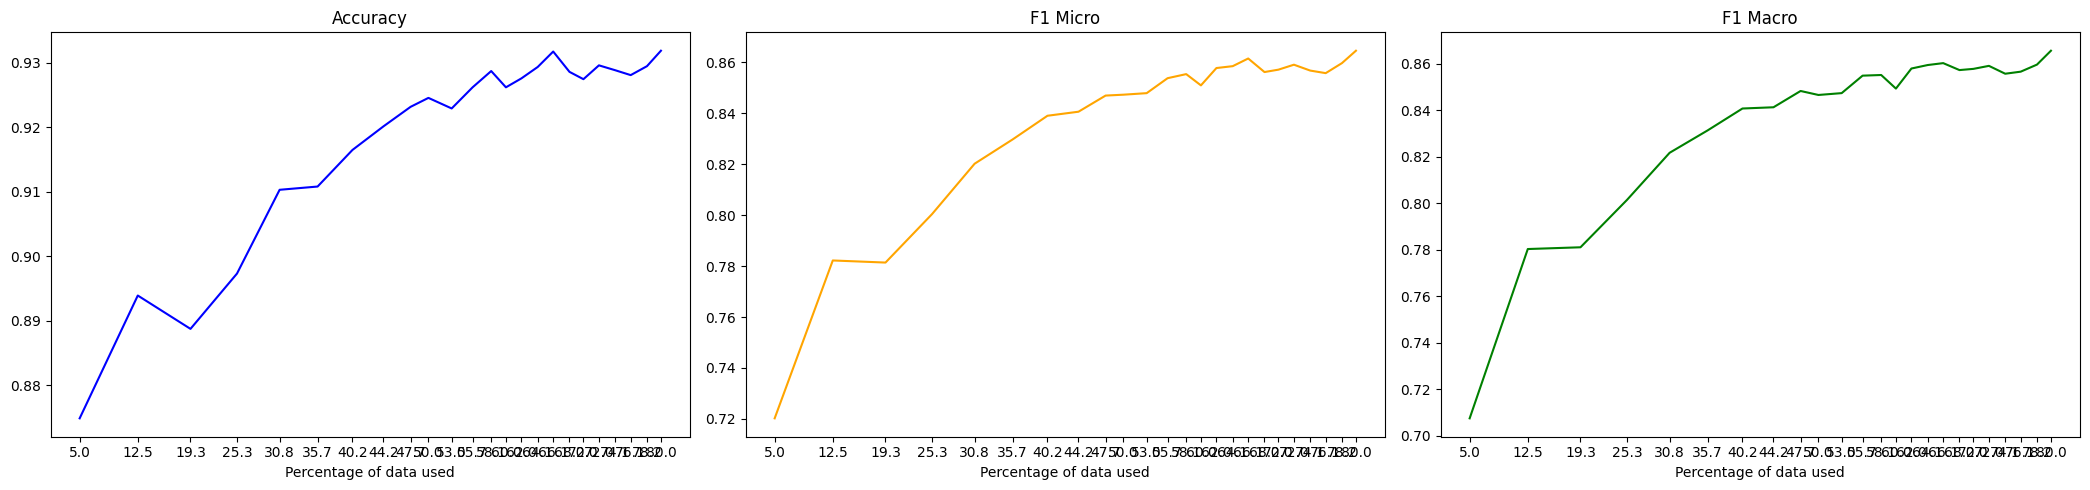

In [ ]:
active_learning(42, 0, 'lc')

# MONTE CARLO DROPOUT

TRIAL 1
Random seed: 42
Launching training on 2 GPUs.
DistributedType.MULTI_GPU


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5825, Accuracy: 0.7519, F1 Micro: 0.0, F1 Macro: 0.0
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.5327, Accuracy: 0.7824, F1 Micro: 0.2355, F1 Macro: 0.1698
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.4418, Accuracy: 0.8053, F1 Micro: 0.4476, F1 Macro: 0.3799
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3815, Accuracy: 0.8144, F1 Micro: 0.5244, F1 Macro: 0.4272
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.3367, Accuracy: 0.825, F1 Micro: 0.5402, F1 Macro: 0.439
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.3027, Accuracy: 0.8426, F1 Micro: 0.6165, F1 Macro: 0.5579
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.2606, Accuracy: 0.8581, F1 Micro: 0.6627, F1 Macro: 0.6291
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.2308, Accuracy: 0.864, F1 Micro: 0.7094, F1 Macro: 0.7011
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1803, 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5933, Accuracy: 0.768, F1 Micro: 0.285, F1 Macro: 0.2514
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4894, Accuracy: 0.8327, F1 Micro: 0.6527, F1 Macro: 0.6545
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3998, Accuracy: 0.8637, F1 Micro: 0.7085, F1 Macro: 0.6942
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3456, Accuracy: 0.8749, F1 Micro: 0.7139, F1 Macro: 0.69
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2662, Accuracy: 0.8908, F1 Micro: 0.7627, F1 Macro: 0.7566
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2, Accuracy: 0.8914, F1 Micro: 0.7673, F1 Macro: 0.7628
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1592, Accuracy: 0.8949, F1 Micro: 0.7775, F1 Macro: 0.7753
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1172, Accuracy: 0.8938, F1 Micro: 0.7878, F1 Macro: 0.7892
Epoch 9/10, Train Loss: 0.0852, Accuracy: 0.896, F1 Micro: 0.78

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5857, Accuracy: 0.7584, F1 Micro: 0.4276, F1 Macro: 0.3493
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4687, Accuracy: 0.858, F1 Micro: 0.7256, F1 Macro: 0.7235
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3732, Accuracy: 0.8894, F1 Micro: 0.7589, F1 Macro: 0.7532
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3131, Accuracy: 0.8969, F1 Micro: 0.7957, F1 Macro: 0.7952
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2367, Accuracy: 0.9083, F1 Micro: 0.8109, F1 Macro: 0.8116
Epoch 6/10, Train Loss: 0.185, Accuracy: 0.909, F1 Micro: 0.8103, F1 Macro: 0.807
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.131, Accuracy: 0.9089, F1 Micro: 0.8117, F1 Macro: 0.8092
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.098, Accuracy: 0.9091, F1 Micro: 0.8183, F1 Macro: 0.819
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0732, Accuracy: 0.9102, F1 Micro: 0.8

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5561, Accuracy: 0.8117, F1 Micro: 0.5632, F1 Macro: 0.5623
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4263, Accuracy: 0.8755, F1 Micro: 0.7408, F1 Macro: 0.7376
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3548, Accuracy: 0.9037, F1 Micro: 0.7965, F1 Macro: 0.7946
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2844, Accuracy: 0.9084, F1 Micro: 0.819, F1 Macro: 0.821
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2159, Accuracy: 0.9114, F1 Micro: 0.8227, F1 Macro: 0.8237
Epoch 6/10, Train Loss: 0.1774, Accuracy: 0.9127, F1 Micro: 0.8152, F1 Macro: 0.811
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1154, Accuracy: 0.9158, F1 Micro: 0.8302, F1 Macro: 0.8299
Epoch 8/10, Train Loss: 0.0941, Accuracy: 0.9149, F1 Micro: 0.8284, F1 Macro: 0.8281
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0669, Accuracy: 0.916, F1 Micro: 0.8311, F1 Macro: 0.8305
Epoch 10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5271, Accuracy: 0.8377, F1 Micro: 0.6382, F1 Macro: 0.6324
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3969, Accuracy: 0.8899, F1 Micro: 0.7702, F1 Macro: 0.77
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3216, Accuracy: 0.9054, F1 Micro: 0.8052, F1 Macro: 0.802
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2616, Accuracy: 0.9123, F1 Micro: 0.8266, F1 Macro: 0.8269
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1939, Accuracy: 0.9191, F1 Micro: 0.8344, F1 Macro: 0.8334
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1464, Accuracy: 0.9205, F1 Micro: 0.8419, F1 Macro: 0.843
Epoch 7/10, Train Loss: 0.1036, Accuracy: 0.9212, F1 Micro: 0.8414, F1 Macro: 0.8422
Epoch 8/10, Train Loss: 0.0705, Accuracy: 0.9196, F1 Micro: 0.8411, F1 Macro: 0.8416
Epoch 9/10, Train Loss: 0.0576, Accuracy: 0.9196, F1 Micro: 0.8312, F1 Macro: 0.827
Higher F1 achieved, saving model
Epoch 10/

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5317, Accuracy: 0.8499, F1 Micro: 0.6756, F1 Macro: 0.6784
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3912, Accuracy: 0.8988, F1 Micro: 0.7974, F1 Macro: 0.7987
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.313, Accuracy: 0.9026, F1 Micro: 0.8122, F1 Macro: 0.8145
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2617, Accuracy: 0.9196, F1 Micro: 0.8365, F1 Macro: 0.8375
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1935, Accuracy: 0.9167, F1 Micro: 0.8387, F1 Macro: 0.8399
Epoch 6/10, Train Loss: 0.1422, Accuracy: 0.9152, F1 Micro: 0.838, F1 Macro: 0.8411
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1081, Accuracy: 0.9191, F1 Micro: 0.8406, F1 Macro: 0.8411
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.07, Accuracy: 0.9223, F1 Micro: 0.8464, F1 Macro: 0.848
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0521, Accuracy: 0.9238, F1 Micro: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5056, Accuracy: 0.8493, F1 Micro: 0.6436, F1 Macro: 0.6189
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3617, Accuracy: 0.9036, F1 Micro: 0.8015, F1 Macro: 0.8018
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2928, Accuracy: 0.9146, F1 Micro: 0.8296, F1 Macro: 0.8298
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2325, Accuracy: 0.9181, F1 Micro: 0.8401, F1 Macro: 0.8425
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1739, Accuracy: 0.9249, F1 Micro: 0.8489, F1 Macro: 0.849
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1212, Accuracy: 0.9275, F1 Micro: 0.8534, F1 Macro: 0.8529
Epoch 7/10, Train Loss: 0.0876, Accuracy: 0.9252, F1 Micro: 0.85, F1 Macro: 0.8504
Epoch 8/10, Train Loss: 0.0599, Accuracy: 0.9233, F1 Micro: 0.8495, F1 Macro: 0.8496
Epoch 9/10, Train Loss: 0.0466, Accuracy: 0.9268, F1 Micro: 0.8528, F1 Macro: 0.8529
Epoch 10/10, Train Loss: 0.0345, Accurac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4978, Accuracy: 0.8659, F1 Micro: 0.6963, F1 Macro: 0.6899
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3595, Accuracy: 0.9044, F1 Micro: 0.8012, F1 Macro: 0.7999
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2836, Accuracy: 0.9173, F1 Micro: 0.8386, F1 Macro: 0.8406
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2225, Accuracy: 0.9241, F1 Micro: 0.8453, F1 Macro: 0.8441
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.161, Accuracy: 0.9201, F1 Micro: 0.8472, F1 Macro: 0.8504
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1162, Accuracy: 0.9277, F1 Micro: 0.8552, F1 Macro: 0.8551
Epoch 7/10, Train Loss: 0.0773, Accuracy: 0.9255, F1 Micro: 0.8529, F1 Macro: 0.8527
Epoch 8/10, Train Loss: 0.0603, Accuracy: 0.9254, F1 Micro: 0.8502, F1 Macro: 0.8491
Epoch 9/10, Train Loss: 0.0474, Accuracy: 0.9269, F1 Micro: 0.8543, F1 Macro: 0.8531
Epoch 10/10, Train Loss: 0.0375, Accur

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4833, Accuracy: 0.87, F1 Micro: 0.7571, F1 Macro: 0.7618
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3334, Accuracy: 0.9089, F1 Micro: 0.8177, F1 Macro: 0.8177
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2691, Accuracy: 0.9172, F1 Micro: 0.8353, F1 Macro: 0.8357
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2041, Accuracy: 0.9236, F1 Micro: 0.8465, F1 Macro: 0.8471
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1505, Accuracy: 0.9274, F1 Micro: 0.8548, F1 Macro: 0.854
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1027, Accuracy: 0.9312, F1 Micro: 0.8602, F1 Macro: 0.8589
Epoch 7/10, Train Loss: 0.0721, Accuracy: 0.9268, F1 Micro: 0.8504, F1 Macro: 0.8508
Epoch 8/10, Train Loss: 0.0537, Accuracy: 0.9265, F1 Micro: 0.853, F1 Macro: 0.8519
Epoch 9/10, Train Loss: 0.0417, Accuracy: 0.9293, F1 Micro: 0.8566, F1 Macro: 0.8557
Epoch 10/10, Train Loss: 0.0349, Accuracy

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4755, Accuracy: 0.8724, F1 Micro: 0.7315, F1 Macro: 0.731
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3357, Accuracy: 0.9099, F1 Micro: 0.8137, F1 Macro: 0.8132
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2638, Accuracy: 0.9176, F1 Micro: 0.84, F1 Macro: 0.8426
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2027, Accuracy: 0.9233, F1 Micro: 0.8497, F1 Macro: 0.8514
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.145, Accuracy: 0.9279, F1 Micro: 0.8505, F1 Macro: 0.8478
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0986, Accuracy: 0.927, F1 Micro: 0.8535, F1 Macro: 0.8546
Epoch 7/10, Train Loss: 0.07, Accuracy: 0.9278, F1 Micro: 0.8525, F1 Macro: 0.8518
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0535, Accuracy: 0.927, F1 Micro: 0.8538, F1 Macro: 0.8537
Epoch 9/10, Train Loss: 0.0371, Accuracy: 0.9255, F1 Micro: 0.8532, F1 Macro: 0.8538
Epoch 10/10,

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4591, Accuracy: 0.8798, F1 Micro: 0.7627, F1 Macro: 0.7667
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.319, Accuracy: 0.9088, F1 Micro: 0.8107, F1 Macro: 0.8085
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.244, Accuracy: 0.9221, F1 Micro: 0.8431, F1 Macro: 0.8436
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1805, Accuracy: 0.9221, F1 Micro: 0.8481, F1 Macro: 0.8496
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1361, Accuracy: 0.9298, F1 Micro: 0.8594, F1 Macro: 0.8585
Epoch 6/10, Train Loss: 0.0989, Accuracy: 0.9289, F1 Micro: 0.8563, F1 Macro: 0.8558
Epoch 7/10, Train Loss: 0.0674, Accuracy: 0.928, F1 Micro: 0.8561, F1 Macro: 0.8551
Epoch 8/10, Train Loss: 0.0484, Accuracy: 0.9275, F1 Micro: 0.8547, F1 Macro: 0.8553
Epoch 9/10, Train Loss: 0.0373, Accuracy: 0.9292, F1 Micro: 0.8496, F1 Macro: 0.8456
Epoch 10/10, Train Loss: 0.034, Accuracy: 0.9308, F1 Micro: 0.8589, F1 Ma

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4532, Accuracy: 0.8871, F1 Micro: 0.7598, F1 Macro: 0.754
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3151, Accuracy: 0.9117, F1 Micro: 0.8221, F1 Macro: 0.8223
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2433, Accuracy: 0.9207, F1 Micro: 0.8449, F1 Macro: 0.8463
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1854, Accuracy: 0.9292, F1 Micro: 0.8566, F1 Macro: 0.857
Epoch 5/10, Train Loss: 0.1314, Accuracy: 0.9234, F1 Micro: 0.8495, F1 Macro: 0.8487
Epoch 6/10, Train Loss: 0.0939, Accuracy: 0.9278, F1 Micro: 0.8535, F1 Macro: 0.8523
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0601, Accuracy: 0.9297, F1 Micro: 0.8566, F1 Macro: 0.856
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0494, Accuracy: 0.9307, F1 Micro: 0.8582, F1 Macro: 0.8569
Epoch 9/10, Train Loss: 0.0338, Accuracy: 0.9234, F1 Micro: 0.8525, F1 Macro: 0.854
Epoch 10/10, Train Loss: 0.0268, Accuracy

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4478, Accuracy: 0.8896, F1 Micro: 0.7741, F1 Macro: 0.7743
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.286, Accuracy: 0.9137, F1 Micro: 0.823, F1 Macro: 0.8234
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2231, Accuracy: 0.9228, F1 Micro: 0.8452, F1 Macro: 0.8444
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1734, Accuracy: 0.9214, F1 Micro: 0.8496, F1 Macro: 0.8525
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1276, Accuracy: 0.9252, F1 Micro: 0.8548, F1 Macro: 0.8563
Epoch 6/10, Train Loss: 0.086, Accuracy: 0.9259, F1 Micro: 0.8539, F1 Macro: 0.8549
Epoch 7/10, Train Loss: 0.0626, Accuracy: 0.9277, F1 Micro: 0.8535, F1 Macro: 0.8539
Epoch 8/10, Train Loss: 0.0465, Accuracy: 0.925, F1 Micro: 0.8518, F1 Macro: 0.8518
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0361, Accuracy: 0.9278, F1 Micro: 0.8577, F1 Macro: 0.8577
Higher F1 achieved, saving model
Epoch 10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4409, Accuracy: 0.885, F1 Micro: 0.7798, F1 Macro: 0.786
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2879, Accuracy: 0.9181, F1 Micro: 0.822, F1 Macro: 0.8183
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2174, Accuracy: 0.9241, F1 Micro: 0.8468, F1 Macro: 0.8464
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1681, Accuracy: 0.9259, F1 Micro: 0.8487, F1 Macro: 0.8451
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1234, Accuracy: 0.924, F1 Micro: 0.8497, F1 Macro: 0.8498
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0864, Accuracy: 0.9278, F1 Micro: 0.8557, F1 Macro: 0.8549
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0576, Accuracy: 0.9301, F1 Micro: 0.8607, F1 Macro: 0.8606
Epoch 8/10, Train Loss: 0.0407, Accuracy: 0.9287, F1 Micro: 0.8568, F1 Macro: 0.8568
Epoch 9/10, Train Loss: 0.0339, Accuracy: 0.9316, F1 Micro: 0.8587, F1 Macro: 0.8572
Epoch 10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4255, Accuracy: 0.8873, F1 Micro: 0.7651, F1 Macro: 0.7602
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2815, Accuracy: 0.9126, F1 Micro: 0.8277, F1 Macro: 0.8285
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.218, Accuracy: 0.9219, F1 Micro: 0.8447, F1 Macro: 0.8441
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1594, Accuracy: 0.925, F1 Micro: 0.8518, F1 Macro: 0.8514
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1132, Accuracy: 0.9287, F1 Micro: 0.857, F1 Macro: 0.8571
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0814, Accuracy: 0.932, F1 Micro: 0.864, F1 Macro: 0.8645
Epoch 7/10, Train Loss: 0.058, Accuracy: 0.9289, F1 Micro: 0.8547, F1 Macro: 0.8558
Epoch 8/10, Train Loss: 0.0411, Accuracy: 0.9303, F1 Micro: 0.8623, F1 Macro: 0.8624
Epoch 9/10, Train Loss: 0.0321, Accuracy: 0.9282, F1 Micro: 0.8565, F1 Macro: 0.8544
Epoch 10/10, Train Loss: 0.025, Accuracy: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4142, Accuracy: 0.8865, F1 Micro: 0.7343, F1 Macro: 0.7216
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2683, Accuracy: 0.9151, F1 Micro: 0.8237, F1 Macro: 0.8228
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2054, Accuracy: 0.9234, F1 Micro: 0.8359, F1 Macro: 0.8313
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.157, Accuracy: 0.9235, F1 Micro: 0.8496, F1 Macro: 0.851
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1102, Accuracy: 0.9267, F1 Micro: 0.8525, F1 Macro: 0.851
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.075, Accuracy: 0.9278, F1 Micro: 0.8545, F1 Macro: 0.8529
Epoch 7/10, Train Loss: 0.0527, Accuracy: 0.9298, F1 Micro: 0.8543, F1 Macro: 0.8536
Epoch 8/10, Train Loss: 0.0398, Accuracy: 0.9289, F1 Micro: 0.8539, F1 Macro: 0.8527
Epoch 9/10, Train Loss: 0.0309, Accuracy: 0.9269, F1 Micro: 0.852, F1 Macro: 0.8517
Epoch 10/10, Train Loss: 0.0267, Accuracy:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4073, Accuracy: 0.8935, F1 Micro: 0.791, F1 Macro: 0.794
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2599, Accuracy: 0.9176, F1 Micro: 0.8327, F1 Macro: 0.8334
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1938, Accuracy: 0.9216, F1 Micro: 0.8393, F1 Macro: 0.8352
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1404, Accuracy: 0.9291, F1 Micro: 0.8558, F1 Macro: 0.8561
Epoch 5/10, Train Loss: 0.103, Accuracy: 0.9273, F1 Micro: 0.8556, F1 Macro: 0.8569
Epoch 6/10, Train Loss: 0.0704, Accuracy: 0.9257, F1 Micro: 0.8527, F1 Macro: 0.8532
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0501, Accuracy: 0.9296, F1 Micro: 0.8599, F1 Macro: 0.8596
Epoch 8/10, Train Loss: 0.0394, Accuracy: 0.9257, F1 Micro: 0.8568, F1 Macro: 0.8579
Epoch 9/10, Train Loss: 0.0272, Accuracy: 0.9301, F1 Micro: 0.8595, F1 Macro: 0.8597
Epoch 10/10, Train Loss: 0.0239, Accuracy: 0.9277, F1 Micro: 0.8551, F1 M

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4059, Accuracy: 0.8948, F1 Micro: 0.7863, F1 Macro: 0.7855
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.252, Accuracy: 0.9129, F1 Micro: 0.8258, F1 Macro: 0.8258
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1878, Accuracy: 0.9278, F1 Micro: 0.8528, F1 Macro: 0.8511
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1445, Accuracy: 0.9287, F1 Micro: 0.8545, F1 Macro: 0.8541
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.0957, Accuracy: 0.9313, F1 Micro: 0.8602, F1 Macro: 0.86
Epoch 6/10, Train Loss: 0.0704, Accuracy: 0.9258, F1 Micro: 0.8529, F1 Macro: 0.8518
Epoch 7/10, Train Loss: 0.0496, Accuracy: 0.9304, F1 Micro: 0.8574, F1 Macro: 0.8542
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0333, Accuracy: 0.9308, F1 Micro: 0.861, F1 Macro: 0.8602
Epoch 9/10, Train Loss: 0.0317, Accuracy: 0.9313, F1 Micro: 0.8597, F1 Macro: 0.8595
Epoch 10/10, Train Loss: 0.0233, Accuracy

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3987, Accuracy: 0.8991, F1 Micro: 0.7935, F1 Macro: 0.793
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2422, Accuracy: 0.9171, F1 Micro: 0.8353, F1 Macro: 0.8358
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1825, Accuracy: 0.9225, F1 Micro: 0.8464, F1 Macro: 0.8467
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1354, Accuracy: 0.9279, F1 Micro: 0.8563, F1 Macro: 0.8572
Epoch 5/10, Train Loss: 0.0955, Accuracy: 0.9248, F1 Micro: 0.8552, F1 Macro: 0.8581
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0705, Accuracy: 0.9284, F1 Micro: 0.8563, F1 Macro: 0.8557
Epoch 7/10, Train Loss: 0.0494, Accuracy: 0.9268, F1 Micro: 0.856, F1 Macro: 0.8566
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0347, Accuracy: 0.9311, F1 Micro: 0.8632, F1 Macro: 0.8637
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0283, Accuracy: 0.932, F1 Micro: 0.8651, F1 Macro: 0.8649
Epoch 1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3927, Accuracy: 0.8902, F1 Micro: 0.7906, F1 Macro: 0.7923
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2437, Accuracy: 0.9196, F1 Micro: 0.8325, F1 Macro: 0.8305
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1791, Accuracy: 0.9211, F1 Micro: 0.8479, F1 Macro: 0.8493
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1333, Accuracy: 0.9216, F1 Micro: 0.8484, F1 Macro: 0.8494
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.0953, Accuracy: 0.9296, F1 Micro: 0.8573, F1 Macro: 0.857
Epoch 6/10, Train Loss: 0.0623, Accuracy: 0.9291, F1 Micro: 0.8521, F1 Macro: 0.8514
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0435, Accuracy: 0.9286, F1 Micro: 0.8579, F1 Macro: 0.859
Epoch 8/10, Train Loss: 0.0355, Accuracy: 0.927, F1 Micro: 0.8513, F1 Macro: 0.8519
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0273, Accuracy: 0.9298, F1 Micro: 0.859, F1 Macro: 0.8582
Epoch 10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3775, Accuracy: 0.8998, F1 Micro: 0.7932, F1 Macro: 0.7931
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2276, Accuracy: 0.9139, F1 Micro: 0.8311, F1 Macro: 0.8331
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1763, Accuracy: 0.9262, F1 Micro: 0.8485, F1 Macro: 0.8488
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1276, Accuracy: 0.9273, F1 Micro: 0.8499, F1 Macro: 0.8479
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.0946, Accuracy: 0.9265, F1 Micro: 0.8538, F1 Macro: 0.8547
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0605, Accuracy: 0.9275, F1 Micro: 0.8556, F1 Macro: 0.8566
Epoch 7/10, Train Loss: 0.0483, Accuracy: 0.9277, F1 Micro: 0.8548, F1 Macro: 0.8549
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0312, Accuracy: 0.9292, F1 Micro: 0.8567, F1 Macro: 0.856
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0277, Accuracy: 0.9279, F1 Micr

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.366, Accuracy: 0.895, F1 Micro: 0.7739, F1 Macro: 0.7638
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2207, Accuracy: 0.9183, F1 Micro: 0.8317, F1 Macro: 0.8306
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1656, Accuracy: 0.9291, F1 Micro: 0.8545, F1 Macro: 0.8535
Epoch 4/10, Train Loss: 0.1224, Accuracy: 0.9288, F1 Micro: 0.853, F1 Macro: 0.8514
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.0868, Accuracy: 0.9296, F1 Micro: 0.8592, F1 Macro: 0.8586
Epoch 6/10, Train Loss: 0.0618, Accuracy: 0.9274, F1 Micro: 0.8537, F1 Macro: 0.8538
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0426, Accuracy: 0.9303, F1 Micro: 0.86, F1 Macro: 0.86
Epoch 8/10, Train Loss: 0.0303, Accuracy: 0.9272, F1 Micro: 0.8575, F1 Macro: 0.8592
Epoch 9/10, Train Loss: 0.0253, Accuracy: 0.9278, F1 Micro: 0.8554, F1 Macro: 0.855
Epoch 10/10, Train Loss: 0.0192, Accuracy: 0.9269, F1 Micro: 0.8549, F1 Macro:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3648, Accuracy: 0.9001, F1 Micro: 0.7894, F1 Macro: 0.7844
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2141, Accuracy: 0.9201, F1 Micro: 0.8365, F1 Macro: 0.8351
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1593, Accuracy: 0.9226, F1 Micro: 0.8473, F1 Macro: 0.8464
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1226, Accuracy: 0.9317, F1 Micro: 0.861, F1 Macro: 0.86
Epoch 5/10, Train Loss: 0.0842, Accuracy: 0.9307, F1 Micro: 0.8571, F1 Macro: 0.8563
Epoch 6/10, Train Loss: 0.0575, Accuracy: 0.9289, F1 Micro: 0.8597, F1 Macro: 0.8594
Epoch 7/10, Train Loss: 0.0406, Accuracy: 0.9284, F1 Micro: 0.8573, F1 Macro: 0.8553
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0304, Accuracy: 0.9283, F1 Micro: 0.8621, F1 Macro: 0.8631
Epoch 9/10, Train Loss: 0.0232, Accuracy: 0.9278, F1 Micro: 0.8559, F1 Macro: 0.8542
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.0192, Accurac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3551, Accuracy: 0.8993, F1 Micro: 0.7843, F1 Macro: 0.7776
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2147, Accuracy: 0.9165, F1 Micro: 0.8369, F1 Macro: 0.8378
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.159, Accuracy: 0.9216, F1 Micro: 0.8482, F1 Macro: 0.8492
Epoch 4/10, Train Loss: 0.1132, Accuracy: 0.9254, F1 Micro: 0.8439, F1 Macro: 0.8392
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.0851, Accuracy: 0.9282, F1 Micro: 0.857, F1 Macro: 0.8557
Epoch 6/10, Train Loss: 0.0526, Accuracy: 0.9297, F1 Micro: 0.8546, F1 Macro: 0.8519
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0366, Accuracy: 0.9284, F1 Micro: 0.8577, F1 Macro: 0.8581
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0293, Accuracy: 0.9301, F1 Micro: 0.8603, F1 Macro: 0.8607
Epoch 9/10, Train Loss: 0.0194, Accuracy: 0.927, F1 Micro: 0.8554, F1 Macro: 0.8542
Higher F1 achieved, saving model
Epoch 1

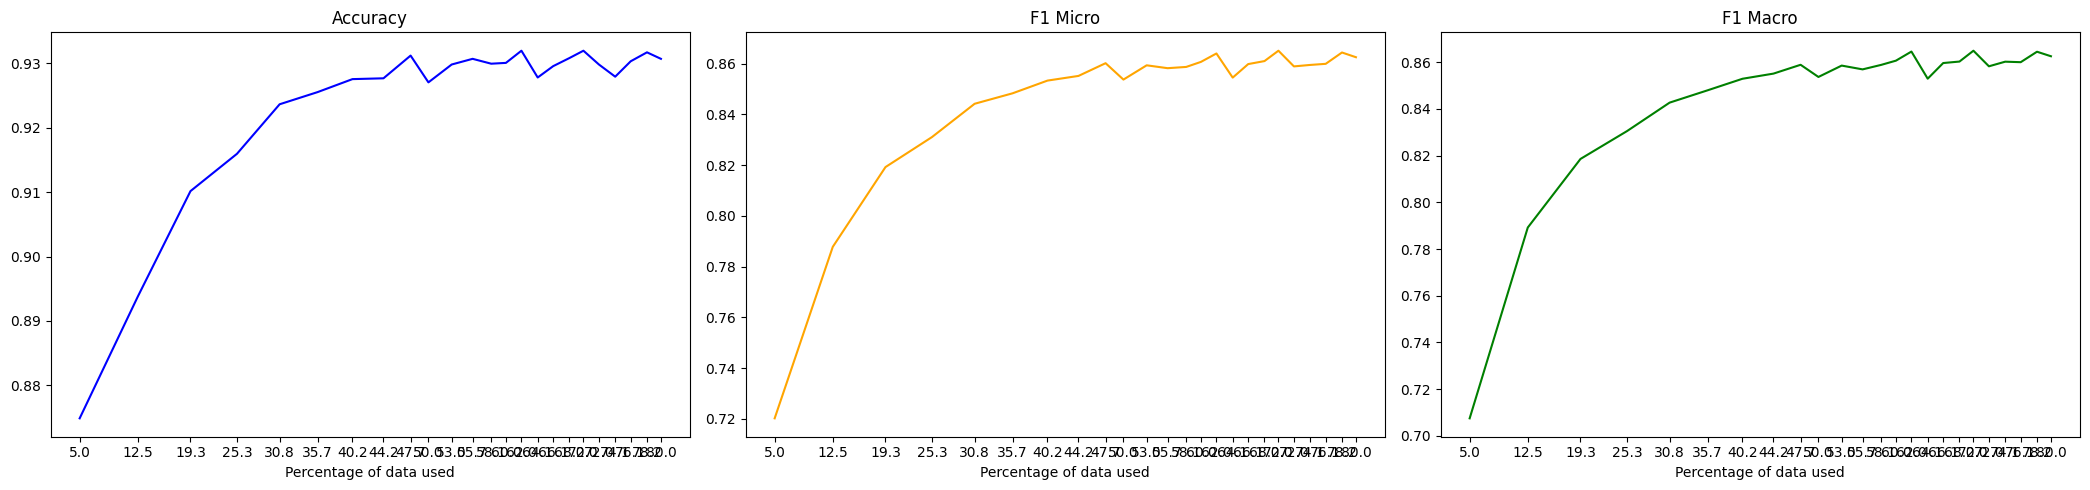

In [ ]:
active_learning(42, 0, 'mc')

# KMEANS

TRIAL 1
Random seed: 42
Launching training on 2 GPUs.
DistributedType.MULTI_GPU


pytorch_model.bin:   0%|          | 0.00/498M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5825, Accuracy: 0.7519, F1 Micro: 0.0, F1 Macro: 0.0
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.5327, Accuracy: 0.7824, F1 Micro: 0.2355, F1 Macro: 0.1698
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.4418, Accuracy: 0.8053, F1 Micro: 0.4476, F1 Macro: 0.3799
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3815, Accuracy: 0.8144, F1 Micro: 0.5244, F1 Macro: 0.4272
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.3367, Accuracy: 0.825, F1 Micro: 0.5402, F1 Macro: 0.439
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.3027, Accuracy: 0.8426, F1 Micro: 0.6165, F1 Macro: 0.5579
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.2606, Accuracy: 0.8581, F1 Micro: 0.6627, F1 Macro: 0.6291
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.2308, Accuracy: 0.864, F1 Micro: 0.7094, F1 Macro: 0.7011
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1803, 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5409, Accuracy: 0.7818, F1 Micro: 0.2336, F1 Macro: 0.1812
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3984, Accuracy: 0.8199, F1 Micro: 0.5197, F1 Macro: 0.4419
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3214, Accuracy: 0.8589, F1 Micro: 0.6629, F1 Macro: 0.6321
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2634, Accuracy: 0.8742, F1 Micro: 0.6994, F1 Macro: 0.6764
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1915, Accuracy: 0.8847, F1 Micro: 0.7442, F1 Macro: 0.7293
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1568, Accuracy: 0.8928, F1 Micro: 0.7737, F1 Macro: 0.7704
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1101, Accuracy: 0.8911, F1 Micro: 0.7748, F1 Macro: 0.7703
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0845, Accuracy: 0.8918, F1 Micro: 0.7828, F1 Macro: 0.7828
Epoch 9/10, Train Loss: 0.0604, Accuracy: 0.889, F1 Micr

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5068, Accuracy: 0.811, F1 Micro: 0.4838, F1 Macro: 0.4299
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3547, Accuracy: 0.8566, F1 Micro: 0.6635, F1 Macro: 0.6346
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2667, Accuracy: 0.8773, F1 Micro: 0.713, F1 Macro: 0.6946
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2128, Accuracy: 0.8919, F1 Micro: 0.7754, F1 Macro: 0.772
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1554, Accuracy: 0.8976, F1 Micro: 0.7844, F1 Macro: 0.7843
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1142, Accuracy: 0.9028, F1 Micro: 0.7957, F1 Macro: 0.7945
Epoch 7/10, Train Loss: 0.0809, Accuracy: 0.902, F1 Micro: 0.785, F1 Macro: 0.7794
Epoch 8/10, Train Loss: 0.0577, Accuracy: 0.9012, F1 Micro: 0.7878, F1 Macro: 0.7771
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0454, Accuracy: 0.9022, F1 Micro: 0.7973, F1 Macro: 0.7935
Epoch 10/

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4824, Accuracy: 0.8241, F1 Micro: 0.5591, F1 Macro: 0.4806
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3175, Accuracy: 0.8856, F1 Micro: 0.7527, F1 Macro: 0.7531
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2447, Accuracy: 0.8997, F1 Micro: 0.7988, F1 Macro: 0.8007
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1834, Accuracy: 0.9073, F1 Micro: 0.808, F1 Macro: 0.8058
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1353, Accuracy: 0.9059, F1 Micro: 0.8218, F1 Macro: 0.8252
Epoch 6/10, Train Loss: 0.1046, Accuracy: 0.9138, F1 Micro: 0.8206, F1 Macro: 0.8192
Epoch 7/10, Train Loss: 0.0671, Accuracy: 0.9097, F1 Micro: 0.8079, F1 Macro: 0.8031
Epoch 8/10, Train Loss: 0.0487, Accuracy: 0.9122, F1 Micro: 0.8171, F1 Macro: 0.815
Epoch 9/10, Train Loss: 0.0381, Accuracy: 0.9112, F1 Micro: 0.8139, F1 Macro: 0.8108
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.0323, Accura

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4641, Accuracy: 0.8362, F1 Micro: 0.5831, F1 Macro: 0.4981
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2946, Accuracy: 0.8886, F1 Micro: 0.7668, F1 Macro: 0.7648
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2335, Accuracy: 0.8989, F1 Micro: 0.7973, F1 Macro: 0.798
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1728, Accuracy: 0.9046, F1 Micro: 0.806, F1 Macro: 0.8054
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1112, Accuracy: 0.9086, F1 Micro: 0.8097, F1 Macro: 0.8067
Epoch 6/10, Train Loss: 0.0921, Accuracy: 0.9103, F1 Micro: 0.8087, F1 Macro: 0.8025
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0606, Accuracy: 0.9113, F1 Micro: 0.8146, F1 Macro: 0.81
Epoch 8/10, Train Loss: 0.043, Accuracy: 0.911, F1 Micro: 0.812, F1 Macro: 0.8081
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0363, Accuracy: 0.9127, F1 Micro: 0.8233, F1 Macro: 0.8224
Epoch 10/10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4599, Accuracy: 0.8638, F1 Micro: 0.7041, F1 Macro: 0.6992
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2926, Accuracy: 0.8981, F1 Micro: 0.7889, F1 Macro: 0.7895
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2164, Accuracy: 0.9049, F1 Micro: 0.8081, F1 Macro: 0.8072
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1534, Accuracy: 0.9139, F1 Micro: 0.8288, F1 Macro: 0.8311
Epoch 5/10, Train Loss: 0.1223, Accuracy: 0.91, F1 Micro: 0.8227, F1 Macro: 0.826
Epoch 6/10, Train Loss: 0.0854, Accuracy: 0.9158, F1 Micro: 0.8216, F1 Macro: 0.8168
Epoch 7/10, Train Loss: 0.0573, Accuracy: 0.9132, F1 Micro: 0.8197, F1 Macro: 0.8157
Epoch 8/10, Train Loss: 0.0422, Accuracy: 0.9124, F1 Micro: 0.8207, F1 Macro: 0.8202
Epoch 9/10, Train Loss: 0.0336, Accuracy: 0.9118, F1 Micro: 0.826, F1 Macro: 0.8254
Epoch 10/10, Train Loss: 0.024, Accuracy: 0.9134, F1 Micro: 0.8283, F1 Macro: 0.8281

 Iteration 3502: Accu

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4388, Accuracy: 0.871, F1 Micro: 0.6995, F1 Macro: 0.6875
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2692, Accuracy: 0.8972, F1 Micro: 0.7911, F1 Macro: 0.7916
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1974, Accuracy: 0.9036, F1 Micro: 0.8129, F1 Macro: 0.8132
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1459, Accuracy: 0.9147, F1 Micro: 0.8237, F1 Macro: 0.8221
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1072, Accuracy: 0.9104, F1 Micro: 0.8245, F1 Macro: 0.8255
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0765, Accuracy: 0.9156, F1 Micro: 0.8329, F1 Macro: 0.8328
Epoch 7/10, Train Loss: 0.0506, Accuracy: 0.9172, F1 Micro: 0.8327, F1 Macro: 0.8319
Epoch 8/10, Train Loss: 0.0368, Accuracy: 0.9162, F1 Micro: 0.8284, F1 Macro: 0.8267
Epoch 9/10, Train Loss: 0.0317, Accuracy: 0.9151, F1 Micro: 0.8327, F1 Macro: 0.834
Epoch 10/10, Train Loss: 0.0282, Accura

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4292, Accuracy: 0.8702, F1 Micro: 0.6875, F1 Macro: 0.6639
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2699, Accuracy: 0.8998, F1 Micro: 0.7898, F1 Macro: 0.7865
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1907, Accuracy: 0.9152, F1 Micro: 0.8259, F1 Macro: 0.8264
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1448, Accuracy: 0.919, F1 Micro: 0.8308, F1 Macro: 0.8285
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1067, Accuracy: 0.9157, F1 Micro: 0.8321, F1 Macro: 0.8332
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0761, Accuracy: 0.9192, F1 Micro: 0.8387, F1 Macro: 0.8394
Epoch 7/10, Train Loss: 0.0494, Accuracy: 0.9183, F1 Micro: 0.8385, F1 Macro: 0.8385
Epoch 8/10, Train Loss: 0.0361, Accuracy: 0.9175, F1 Micro: 0.8293, F1 Macro: 0.8287
Epoch 9/10, Train Loss: 0.029, Accuracy: 0.9187, F1 Micro: 0.8385, F1 Macro: 0.8382
Epoch 10/10, Train Loss: 0.0214, Accura

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4304, Accuracy: 0.8807, F1 Micro: 0.7355, F1 Macro: 0.7263
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.254, Accuracy: 0.9062, F1 Micro: 0.8062, F1 Macro: 0.8066
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1879, Accuracy: 0.9196, F1 Micro: 0.8354, F1 Macro: 0.8344
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1455, Accuracy: 0.9214, F1 Micro: 0.8449, F1 Macro: 0.8465
Epoch 5/10, Train Loss: 0.1032, Accuracy: 0.9186, F1 Micro: 0.8389, F1 Macro: 0.8407
Epoch 6/10, Train Loss: 0.0635, Accuracy: 0.9178, F1 Micro: 0.8409, F1 Macro: 0.8437
Epoch 7/10, Train Loss: 0.049, Accuracy: 0.919, F1 Micro: 0.8383, F1 Macro: 0.8387
Epoch 8/10, Train Loss: 0.0349, Accuracy: 0.9214, F1 Micro: 0.8447, F1 Macro: 0.8447
Epoch 9/10, Train Loss: 0.028, Accuracy: 0.9234, F1 Micro: 0.8384, F1 Macro: 0.8355
Epoch 10/10, Train Loss: 0.0221, Accuracy: 0.921, F1 Micro: 0.8322, F1 Macro: 0.8303

 Iteration 4679: Accu

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.418, Accuracy: 0.8808, F1 Micro: 0.7299, F1 Macro: 0.7158
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2503, Accuracy: 0.9078, F1 Micro: 0.81, F1 Macro: 0.8088
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1871, Accuracy: 0.9142, F1 Micro: 0.8221, F1 Macro: 0.8182
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1315, Accuracy: 0.9189, F1 Micro: 0.8382, F1 Macro: 0.8385
Epoch 5/10, Train Loss: 0.0952, Accuracy: 0.918, F1 Micro: 0.8373, F1 Macro: 0.8382
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0647, Accuracy: 0.9194, F1 Micro: 0.8412, F1 Macro: 0.8419
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0413, Accuracy: 0.9205, F1 Micro: 0.8419, F1 Macro: 0.842
Epoch 8/10, Train Loss: 0.0335, Accuracy: 0.9202, F1 Micro: 0.8377, F1 Macro: 0.8381
Epoch 9/10, Train Loss: 0.0284, Accuracy: 0.92, F1 Micro: 0.8296, F1 Macro: 0.8251
Epoch 10/10, Train Loss: 0.0189, Accuracy: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4056, Accuracy: 0.8865, F1 Micro: 0.7592, F1 Macro: 0.7583
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2504, Accuracy: 0.9103, F1 Micro: 0.8092, F1 Macro: 0.8078
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1908, Accuracy: 0.9176, F1 Micro: 0.8342, F1 Macro: 0.8346
Epoch 4/10, Train Loss: 0.129, Accuracy: 0.9202, F1 Micro: 0.8335, F1 Macro: 0.8332
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.0938, Accuracy: 0.9187, F1 Micro: 0.8411, F1 Macro: 0.8423
Epoch 6/10, Train Loss: 0.0646, Accuracy: 0.922, F1 Micro: 0.8366, F1 Macro: 0.8344
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0443, Accuracy: 0.923, F1 Micro: 0.8471, F1 Macro: 0.8475
Epoch 8/10, Train Loss: 0.0346, Accuracy: 0.9225, F1 Micro: 0.8439, F1 Macro: 0.8435
Epoch 9/10, Train Loss: 0.027, Accuracy: 0.9219, F1 Micro: 0.8419, F1 Macro: 0.8431
Epoch 10/10, Train Loss: 0.022, Accuracy: 0.9221, F1 Micro: 0.8443, F1 Mac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4027, Accuracy: 0.8865, F1 Micro: 0.7466, F1 Macro: 0.7351
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.243, Accuracy: 0.9105, F1 Micro: 0.8084, F1 Macro: 0.8016
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1814, Accuracy: 0.9131, F1 Micro: 0.8328, F1 Macro: 0.8362
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1352, Accuracy: 0.9235, F1 Micro: 0.8436, F1 Macro: 0.8409
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1013, Accuracy: 0.9244, F1 Micro: 0.8504, F1 Macro: 0.8513
Epoch 6/10, Train Loss: 0.0655, Accuracy: 0.9205, F1 Micro: 0.8438, F1 Macro: 0.8431
Epoch 7/10, Train Loss: 0.0487, Accuracy: 0.9221, F1 Micro: 0.8474, F1 Macro: 0.8483
Epoch 8/10, Train Loss: 0.0336, Accuracy: 0.9238, F1 Micro: 0.8483, F1 Macro: 0.8484
Epoch 9/10, Train Loss: 0.0251, Accuracy: 0.9228, F1 Micro: 0.8445, F1 Macro: 0.8443
Epoch 10/10, Train Loss: 0.0214, Accuracy: 0.9234, F1 Micro: 0.8465, F1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3863, Accuracy: 0.8916, F1 Micro: 0.7816, F1 Macro: 0.7829
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2387, Accuracy: 0.9103, F1 Micro: 0.8154, F1 Macro: 0.8144
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1757, Accuracy: 0.9195, F1 Micro: 0.8288, F1 Macro: 0.8253
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1239, Accuracy: 0.921, F1 Micro: 0.8463, F1 Macro: 0.8474
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.0918, Accuracy: 0.9245, F1 Micro: 0.8463, F1 Macro: 0.8435
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0627, Accuracy: 0.9224, F1 Micro: 0.8468, F1 Macro: 0.8491
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0424, Accuracy: 0.9258, F1 Micro: 0.851, F1 Macro: 0.8503
Epoch 8/10, Train Loss: 0.0319, Accuracy: 0.9244, F1 Micro: 0.8423, F1 Macro: 0.8392
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0244, Accuracy: 0.9254, F1 Micro

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3953, Accuracy: 0.8899, F1 Micro: 0.7875, F1 Macro: 0.7909
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2361, Accuracy: 0.9134, F1 Micro: 0.8188, F1 Macro: 0.8162
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1752, Accuracy: 0.9214, F1 Micro: 0.8416, F1 Macro: 0.8406
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1294, Accuracy: 0.9277, F1 Micro: 0.8504, F1 Macro: 0.848
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.0879, Accuracy: 0.9252, F1 Micro: 0.8533, F1 Macro: 0.8533
Epoch 6/10, Train Loss: 0.0626, Accuracy: 0.9221, F1 Micro: 0.8517, F1 Macro: 0.854
Epoch 7/10, Train Loss: 0.0422, Accuracy: 0.9228, F1 Micro: 0.8407, F1 Macro: 0.8365
Epoch 8/10, Train Loss: 0.0326, Accuracy: 0.9234, F1 Micro: 0.8458, F1 Macro: 0.8445
Epoch 9/10, Train Loss: 0.0256, Accuracy: 0.9254, F1 Micro: 0.846, F1 Macro: 0.8454
Epoch 10/10, Train Loss: 0.0242, Accuracy: 0.9253, F1 Micro: 0.8532, F1 M

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.395, Accuracy: 0.8905, F1 Micro: 0.7886, F1 Macro: 0.7929
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2389, Accuracy: 0.9139, F1 Micro: 0.8217, F1 Macro: 0.8216
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.178, Accuracy: 0.9197, F1 Micro: 0.8428, F1 Macro: 0.8441
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1312, Accuracy: 0.9216, F1 Micro: 0.8457, F1 Macro: 0.8465
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.0931, Accuracy: 0.9252, F1 Micro: 0.8515, F1 Macro: 0.8518
Epoch 6/10, Train Loss: 0.0684, Accuracy: 0.9221, F1 Micro: 0.8373, F1 Macro: 0.8283
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0452, Accuracy: 0.9259, F1 Micro: 0.856, F1 Macro: 0.8571
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0357, Accuracy: 0.9282, F1 Micro: 0.8566, F1 Macro: 0.8562
Epoch 9/10, Train Loss: 0.027, Accuracy: 0.9259, F1 Micro: 0.8537, F1 Macro: 0.8532
Epoch 10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.387, Accuracy: 0.8931, F1 Micro: 0.7809, F1 Macro: 0.7836
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2364, Accuracy: 0.9112, F1 Micro: 0.822, F1 Macro: 0.8208
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.177, Accuracy: 0.919, F1 Micro: 0.8353, F1 Macro: 0.8323
Epoch 4/10, Train Loss: 0.1226, Accuracy: 0.92, F1 Micro: 0.8315, F1 Macro: 0.823
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.0877, Accuracy: 0.9228, F1 Micro: 0.8361, F1 Macro: 0.832
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0597, Accuracy: 0.9265, F1 Micro: 0.8541, F1 Macro: 0.8533
Epoch 7/10, Train Loss: 0.0426, Accuracy: 0.928, F1 Micro: 0.8514, F1 Macro: 0.8496
Epoch 8/10, Train Loss: 0.0311, Accuracy: 0.9236, F1 Micro: 0.8428, F1 Macro: 0.8389
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0234, Accuracy: 0.9264, F1 Micro: 0.8577, F1 Macro: 0.8595
Epoch 10/10, Train Loss: 0.0215, Accuracy: 0.9

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3847, Accuracy: 0.8986, F1 Micro: 0.7935, F1 Macro: 0.7948
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2318, Accuracy: 0.9172, F1 Micro: 0.8338, F1 Macro: 0.8347
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1709, Accuracy: 0.9136, F1 Micro: 0.8356, F1 Macro: 0.8385
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1308, Accuracy: 0.9278, F1 Micro: 0.855, F1 Macro: 0.8552
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.0859, Accuracy: 0.9292, F1 Micro: 0.8572, F1 Macro: 0.8573
Epoch 6/10, Train Loss: 0.0631, Accuracy: 0.9257, F1 Micro: 0.8519, F1 Macro: 0.8525
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0421, Accuracy: 0.9287, F1 Micro: 0.8589, F1 Macro: 0.8602
Epoch 8/10, Train Loss: 0.0322, Accuracy: 0.9311, F1 Micro: 0.8589, F1 Macro: 0.858
Epoch 9/10, Train Loss: 0.0256, Accuracy: 0.9286, F1 Micro: 0.858, F1 Macro: 0.8583
Epoch 10/10, Train Loss: 0.0197, Accurac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3819, Accuracy: 0.8931, F1 Micro: 0.7945, F1 Macro: 0.7998
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2402, Accuracy: 0.9129, F1 Micro: 0.8167, F1 Macro: 0.8141
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1697, Accuracy: 0.9244, F1 Micro: 0.8413, F1 Macro: 0.8378
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.125, Accuracy: 0.9265, F1 Micro: 0.8494, F1 Macro: 0.8485
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.0808, Accuracy: 0.9268, F1 Micro: 0.8551, F1 Macro: 0.8555
Epoch 6/10, Train Loss: 0.0588, Accuracy: 0.9211, F1 Micro: 0.849, F1 Macro: 0.8509
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0416, Accuracy: 0.9277, F1 Micro: 0.8569, F1 Macro: 0.8577
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0345, Accuracy: 0.9298, F1 Micro: 0.8579, F1 Macro: 0.8572
Epoch 9/10, Train Loss: 0.0253, Accuracy: 0.9286, F1 Micro: 0.8578, F1 Macro: 0.8582
Higher

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.378, Accuracy: 0.8962, F1 Micro: 0.8015, F1 Macro: 0.8053
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2275, Accuracy: 0.9152, F1 Micro: 0.8272, F1 Macro: 0.8243
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1639, Accuracy: 0.9284, F1 Micro: 0.852, F1 Macro: 0.8512
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1203, Accuracy: 0.9263, F1 Micro: 0.8531, F1 Macro: 0.8536
Epoch 5/10, Train Loss: 0.0845, Accuracy: 0.9249, F1 Micro: 0.8531, F1 Macro: 0.8533
Epoch 6/10, Train Loss: 0.0599, Accuracy: 0.9257, F1 Micro: 0.8477, F1 Macro: 0.8461
Epoch 7/10, Train Loss: 0.0458, Accuracy: 0.9262, F1 Micro: 0.8475, F1 Macro: 0.8465
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0313, Accuracy: 0.9301, F1 Micro: 0.8575, F1 Macro: 0.8591
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0266, Accuracy: 0.9292, F1 Micro: 0.8592, F1 Macro: 0.8591
Epoch 10/10, Train Loss: 0.0221, Accura

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3711, Accuracy: 0.8942, F1 Micro: 0.7704, F1 Macro: 0.7659
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2276, Accuracy: 0.9172, F1 Micro: 0.8253, F1 Macro: 0.8234
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1716, Accuracy: 0.9235, F1 Micro: 0.8497, F1 Macro: 0.8524
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.119, Accuracy: 0.9241, F1 Micro: 0.8504, F1 Macro: 0.8513
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.0819, Accuracy: 0.9272, F1 Micro: 0.8571, F1 Macro: 0.8573
Epoch 6/10, Train Loss: 0.057, Accuracy: 0.9263, F1 Micro: 0.8445, F1 Macro: 0.8412
Epoch 7/10, Train Loss: 0.0407, Accuracy: 0.9269, F1 Micro: 0.853, F1 Macro: 0.851
Epoch 8/10, Train Loss: 0.0321, Accuracy: 0.9248, F1 Micro: 0.8532, F1 Macro: 0.8532
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0233, Accuracy: 0.9296, F1 Micro: 0.8586, F1 Macro: 0.8578
Epoch 10/10, Train Loss: 0.021, Accuracy:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.366, Accuracy: 0.9006, F1 Micro: 0.8038, F1 Macro: 0.8037
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2258, Accuracy: 0.9195, F1 Micro: 0.8274, F1 Macro: 0.8246
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1637, Accuracy: 0.9253, F1 Micro: 0.8455, F1 Macro: 0.8426
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1189, Accuracy: 0.9282, F1 Micro: 0.8554, F1 Macro: 0.855
Epoch 5/10, Train Loss: 0.0867, Accuracy: 0.9275, F1 Micro: 0.8548, F1 Macro: 0.8538
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0583, Accuracy: 0.9293, F1 Micro: 0.8594, F1 Macro: 0.8593
Epoch 7/10, Train Loss: 0.0416, Accuracy: 0.9291, F1 Micro: 0.8566, F1 Macro: 0.8572
Epoch 8/10, Train Loss: 0.0356, Accuracy: 0.9272, F1 Micro: 0.8541, F1 Macro: 0.8529
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0245, Accuracy: 0.9309, F1 Micro: 0.8596, F1 Macro: 0.8588
Epoch 10/10, Train Loss: 0.0216, Accura

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3706, Accuracy: 0.8962, F1 Micro: 0.7884, F1 Macro: 0.7873
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2162, Accuracy: 0.9156, F1 Micro: 0.8277, F1 Macro: 0.8237
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1645, Accuracy: 0.9273, F1 Micro: 0.8496, F1 Macro: 0.8495
Epoch 4/10, Train Loss: 0.1197, Accuracy: 0.9246, F1 Micro: 0.8433, F1 Macro: 0.8399
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.0838, Accuracy: 0.9296, F1 Micro: 0.8577, F1 Macro: 0.8569
Epoch 6/10, Train Loss: 0.0581, Accuracy: 0.9297, F1 Micro: 0.8561, F1 Macro: 0.8545
Epoch 7/10, Train Loss: 0.0406, Accuracy: 0.9249, F1 Micro: 0.8526, F1 Macro: 0.8526
Epoch 8/10, Train Loss: 0.032, Accuracy: 0.9268, F1 Micro: 0.8535, F1 Macro: 0.8527
Epoch 9/10, Train Loss: 0.0231, Accuracy: 0.926, F1 Micro: 0.85, F1 Macro: 0.8496
Epoch 10/10, Train Loss: 0.0195, Accuracy: 0.9298, F1 Micro: 0.8565, F1 Macro: 0.8551

 Iteration 7460: Acc

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3579, Accuracy: 0.8947, F1 Micro: 0.7841, F1 Macro: 0.7834
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2194, Accuracy: 0.916, F1 Micro: 0.8274, F1 Macro: 0.8235
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1572, Accuracy: 0.9244, F1 Micro: 0.8428, F1 Macro: 0.8391
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1139, Accuracy: 0.9311, F1 Micro: 0.8621, F1 Macro: 0.8627
Epoch 5/10, Train Loss: 0.0834, Accuracy: 0.9273, F1 Micro: 0.8537, F1 Macro: 0.8535
Epoch 6/10, Train Loss: 0.062, Accuracy: 0.9311, F1 Micro: 0.8605, F1 Macro: 0.8592
Epoch 7/10, Train Loss: 0.0396, Accuracy: 0.9313, F1 Micro: 0.8594, F1 Macro: 0.8579
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0292, Accuracy: 0.9317, F1 Micro: 0.8628, F1 Macro: 0.8627
Epoch 9/10, Train Loss: 0.0229, Accuracy: 0.9292, F1 Micro: 0.8563, F1 Macro: 0.8558
Epoch 10/10, Train Loss: 0.0174, Accuracy: 0.9307, F1 Micro: 0.8598, F1 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3598, Accuracy: 0.8987, F1 Micro: 0.7804, F1 Macro: 0.7755
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2075, Accuracy: 0.9182, F1 Micro: 0.8337, F1 Macro: 0.8335
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1565, Accuracy: 0.9287, F1 Micro: 0.8561, F1 Macro: 0.8563
Epoch 4/10, Train Loss: 0.1172, Accuracy: 0.9235, F1 Micro: 0.8516, F1 Macro: 0.8543
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.0825, Accuracy: 0.9308, F1 Micro: 0.8582, F1 Macro: 0.8571
Epoch 6/10, Train Loss: 0.0551, Accuracy: 0.9252, F1 Micro: 0.8562, F1 Macro: 0.8582
Epoch 7/10, Train Loss: 0.0381, Accuracy: 0.928, F1 Micro: 0.855, F1 Macro: 0.8542
Epoch 8/10, Train Loss: 0.0305, Accuracy: 0.928, F1 Micro: 0.8561, F1 Macro: 0.8566
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0233, Accuracy: 0.9291, F1 Micro: 0.8609, F1 Macro: 0.8615
Epoch 10/10, Train Loss: 0.0163, Accuracy: 0.9304, F1 Micro: 0.8575, F1 M

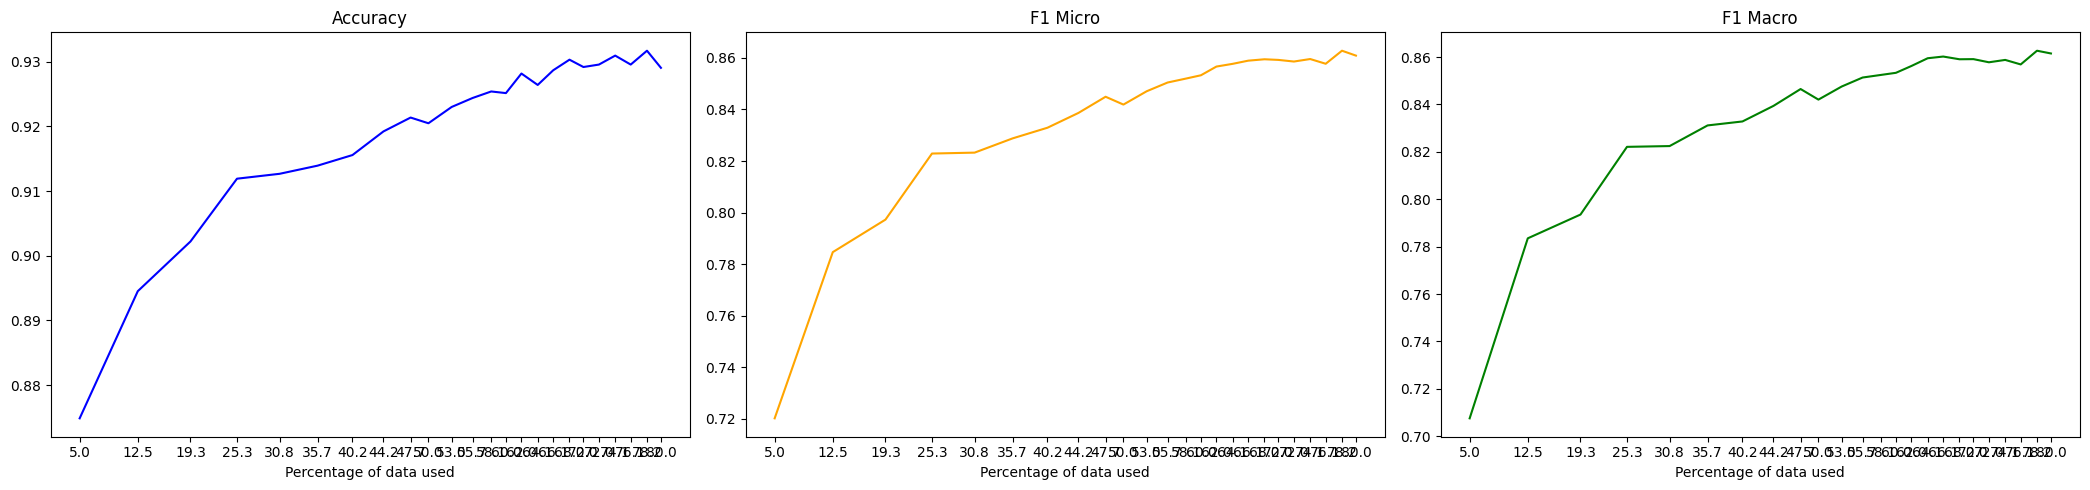

In [24]:
active_learning(42, 0, 'kmeans')

# CORESET

TRIAL 1
Random seed: 42
Launching training on 2 GPUs.
DistributedType.MULTI_GPU


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5825, Accuracy: 0.7519, F1 Micro: 0.0, F1 Macro: 0.0
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.5327, Accuracy: 0.7824, F1 Micro: 0.2355, F1 Macro: 0.1698
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.4418, Accuracy: 0.8053, F1 Micro: 0.4476, F1 Macro: 0.3799
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3815, Accuracy: 0.8144, F1 Micro: 0.5244, F1 Macro: 0.4272
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.3367, Accuracy: 0.825, F1 Micro: 0.5402, F1 Macro: 0.439
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.3027, Accuracy: 0.8426, F1 Micro: 0.6165, F1 Macro: 0.5579
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.2606, Accuracy: 0.8581, F1 Micro: 0.6627, F1 Macro: 0.6291
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.2308, Accuracy: 0.864, F1 Micro: 0.7094, F1 Macro: 0.7011
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1803, 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4039, Accuracy: 0.7765, F1 Micro: 0.3275, F1 Macro: 0.2017
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.23, Accuracy: 0.8056, F1 Micro: 0.5177, F1 Macro: 0.4343
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1815, Accuracy: 0.8288, F1 Micro: 0.5693, F1 Macro: 0.4934
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1405, Accuracy: 0.8334, F1 Micro: 0.5719, F1 Macro: 0.5005
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1157, Accuracy: 0.8546, F1 Micro: 0.6604, F1 Macro: 0.6277
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0887, Accuracy: 0.8643, F1 Micro: 0.6865, F1 Macro: 0.6629
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0756, Accuracy: 0.873, F1 Micro: 0.7191, F1 Macro: 0.7067
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0587, Accuracy: 0.8729, F1 Micro: 0.7253, F1 Macro: 0.7165
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4533, Accuracy: 0.8101, F1 Micro: 0.5656, F1 Macro: 0.4997
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2713, Accuracy: 0.8454, F1 Micro: 0.6459, F1 Macro: 0.6094
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2112, Accuracy: 0.8735, F1 Micro: 0.7068, F1 Macro: 0.6995
Epoch 4/10, Train Loss: 0.1601, Accuracy: 0.872, F1 Micro: 0.701, F1 Macro: 0.6756
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1127, Accuracy: 0.8763, F1 Micro: 0.7139, F1 Macro: 0.6976
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0818, Accuracy: 0.8831, F1 Micro: 0.7373, F1 Macro: 0.7291
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0569, Accuracy: 0.8805, F1 Micro: 0.7408, F1 Macro: 0.7363
Epoch 8/10, Train Loss: 0.0467, Accuracy: 0.8795, F1 Micro: 0.7394, F1 Macro: 0.7319
Epoch 9/10, Train Loss: 0.0349, Accuracy: 0.8779, F1 Micro: 0.7343, F1 Macro: 0.725
Epoch 10/10, Train Loss: 0.0296, Accurac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.393, Accuracy: 0.8097, F1 Micro: 0.5661, F1 Macro: 0.4779
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2162, Accuracy: 0.8616, F1 Micro: 0.7078, F1 Macro: 0.698
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1652, Accuracy: 0.8816, F1 Micro: 0.7302, F1 Macro: 0.7159
Epoch 4/10, Train Loss: 0.1295, Accuracy: 0.88, F1 Micro: 0.7253, F1 Macro: 0.7094
Epoch 5/10, Train Loss: 0.0888, Accuracy: 0.8736, F1 Micro: 0.6978, F1 Macro: 0.6691
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0646, Accuracy: 0.8885, F1 Micro: 0.7691, F1 Macro: 0.766
Epoch 7/10, Train Loss: 0.047, Accuracy: 0.8889, F1 Micro: 0.7643, F1 Macro: 0.758
Epoch 8/10, Train Loss: 0.0361, Accuracy: 0.8865, F1 Micro: 0.7488, F1 Macro: 0.7399
Epoch 9/10, Train Loss: 0.0316, Accuracy: 0.8872, F1 Micro: 0.7659, F1 Macro: 0.7629
Epoch 10/10, Train Loss: 0.0265, Accuracy: 0.8896, F1 Micro: 0.7691, F1 Macro: 0.767

 Iteration 2483: Accurac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4, Accuracy: 0.8293, F1 Micro: 0.5767, F1 Macro: 0.4864
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2276, Accuracy: 0.8724, F1 Micro: 0.7162, F1 Macro: 0.7017
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1719, Accuracy: 0.8913, F1 Micro: 0.7677, F1 Macro: 0.7626
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1463, Accuracy: 0.89, F1 Micro: 0.7774, F1 Macro: 0.777
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.102, Accuracy: 0.8999, F1 Micro: 0.7908, F1 Macro: 0.788
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.071, Accuracy: 0.8989, F1 Micro: 0.792, F1 Macro: 0.79
Epoch 7/10, Train Loss: 0.052, Accuracy: 0.8998, F1 Micro: 0.785, F1 Macro: 0.7809
Epoch 8/10, Train Loss: 0.036, Accuracy: 0.8944, F1 Micro: 0.7729, F1 Macro: 0.7646
Epoch 9/10, Train Loss: 0.0339, Accuracy: 0.8965, F1 Micro: 0.7832, F1 Macro: 0.7779
Epoch 10/10, Train Loss: 0.0266, Accuracy: 0.8959, F

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3799, Accuracy: 0.8545, F1 Micro: 0.717, F1 Macro: 0.7146
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2154, Accuracy: 0.8794, F1 Micro: 0.7484, F1 Macro: 0.7386
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1663, Accuracy: 0.8988, F1 Micro: 0.7953, F1 Macro: 0.7962
Epoch 4/10, Train Loss: 0.1356, Accuracy: 0.8945, F1 Micro: 0.7638, F1 Macro: 0.7546
Epoch 5/10, Train Loss: 0.1045, Accuracy: 0.9012, F1 Micro: 0.7939, F1 Macro: 0.7899
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0687, Accuracy: 0.9049, F1 Micro: 0.8028, F1 Macro: 0.8032
Epoch 7/10, Train Loss: 0.0444, Accuracy: 0.8944, F1 Micro: 0.7733, F1 Macro: 0.7642
Epoch 8/10, Train Loss: 0.0378, Accuracy: 0.8998, F1 Micro: 0.7834, F1 Macro: 0.7772
Epoch 9/10, Train Loss: 0.0287, Accuracy: 0.8996, F1 Micro: 0.795, F1 Macro: 0.7931
Epoch 10/10, Train Loss: 0.0224, Accuracy: 0.9005, F1 Micro: 0.7836, F1 Macro: 0.7763

 Iteration 3502: A

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3881, Accuracy: 0.8522, F1 Micro: 0.6752, F1 Macro: 0.6452
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2256, Accuracy: 0.8885, F1 Micro: 0.7522, F1 Macro: 0.7439
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1739, Accuracy: 0.9006, F1 Micro: 0.794, F1 Macro: 0.7919
Epoch 4/10, Train Loss: 0.1353, Accuracy: 0.8967, F1 Micro: 0.7735, F1 Macro: 0.7601
Epoch 5/10, Train Loss: 0.0972, Accuracy: 0.8984, F1 Micro: 0.7689, F1 Macro: 0.7549
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0672, Accuracy: 0.9039, F1 Micro: 0.8052, F1 Macro: 0.8034
Epoch 7/10, Train Loss: 0.0469, Accuracy: 0.905, F1 Micro: 0.8008, F1 Macro: 0.7972
Epoch 8/10, Train Loss: 0.038, Accuracy: 0.9057, F1 Micro: 0.8048, F1 Macro: 0.8023
Epoch 9/10, Train Loss: 0.0288, Accuracy: 0.9031, F1 Micro: 0.8009, F1 Macro: 0.7984
Epoch 10/10, Train Loss: 0.0243, Accuracy: 0.9041, F1 Micro: 0.8002, F1 Macro: 0.7972

 Iteration 3936: Ac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3779, Accuracy: 0.8727, F1 Micro: 0.7276, F1 Macro: 0.7211
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2167, Accuracy: 0.8994, F1 Micro: 0.7963, F1 Macro: 0.7953
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1615, Accuracy: 0.9031, F1 Micro: 0.8111, F1 Macro: 0.8146
Epoch 4/10, Train Loss: 0.1242, Accuracy: 0.9095, F1 Micro: 0.8006, F1 Macro: 0.7948
Epoch 5/10, Train Loss: 0.0978, Accuracy: 0.9086, F1 Micro: 0.8041, F1 Macro: 0.7989
Epoch 6/10, Train Loss: 0.0641, Accuracy: 0.9094, F1 Micro: 0.809, F1 Macro: 0.8053
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0418, Accuracy: 0.9074, F1 Micro: 0.8175, F1 Macro: 0.8185
Epoch 8/10, Train Loss: 0.0311, Accuracy: 0.9069, F1 Micro: 0.8078, F1 Macro: 0.8072
Epoch 9/10, Train Loss: 0.0251, Accuracy: 0.9095, F1 Micro: 0.8157, F1 Macro: 0.8137
Epoch 10/10, Train Loss: 0.0194, Accuracy: 0.9088, F1 Micro: 0.8169, F1 Macro: 0.8183

 Iteration 4327: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3796, Accuracy: 0.8837, F1 Micro: 0.7676, F1 Macro: 0.7704
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2163, Accuracy: 0.8981, F1 Micro: 0.8035, F1 Macro: 0.8059
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1632, Accuracy: 0.9055, F1 Micro: 0.8126, F1 Macro: 0.8143
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.116, Accuracy: 0.9055, F1 Micro: 0.8153, F1 Macro: 0.817
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.0859, Accuracy: 0.9113, F1 Micro: 0.8217, F1 Macro: 0.8215
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0596, Accuracy: 0.9137, F1 Micro: 0.8256, F1 Macro: 0.8255
Epoch 7/10, Train Loss: 0.0413, Accuracy: 0.9137, F1 Micro: 0.817, F1 Macro: 0.8148
Epoch 8/10, Train Loss: 0.0319, Accuracy: 0.9123, F1 Micro: 0.8127, F1 Macro: 0.8082
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0274, Accuracy: 0.9151, F1 Micro: 0.8256, F1 Macro: 0.824
Epoch 10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3602, Accuracy: 0.8809, F1 Micro: 0.7719, F1 Macro: 0.7775
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2004, Accuracy: 0.8976, F1 Micro: 0.8023, F1 Macro: 0.8049
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1512, Accuracy: 0.9083, F1 Micro: 0.8139, F1 Macro: 0.8144
Epoch 4/10, Train Loss: 0.1112, Accuracy: 0.8971, F1 Micro: 0.8075, F1 Macro: 0.8132
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.084, Accuracy: 0.9105, F1 Micro: 0.8169, F1 Macro: 0.8157
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0525, Accuracy: 0.9128, F1 Micro: 0.8279, F1 Macro: 0.8281
Epoch 7/10, Train Loss: 0.0417, Accuracy: 0.9114, F1 Micro: 0.8191, F1 Macro: 0.8197
Epoch 8/10, Train Loss: 0.0291, Accuracy: 0.9126, F1 Micro: 0.8239, F1 Macro: 0.8245
Epoch 9/10, Train Loss: 0.0251, Accuracy: 0.9105, F1 Micro: 0.8203, F1 Macro: 0.8209
Epoch 10/10, Train Loss: 0.0193, Accuracy: 0.91, F1 Micro: 0.8197, F1 M

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3656, Accuracy: 0.886, F1 Micro: 0.7674, F1 Macro: 0.765
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2107, Accuracy: 0.9017, F1 Micro: 0.8, F1 Macro: 0.8003
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.146, Accuracy: 0.9138, F1 Micro: 0.8226, F1 Macro: 0.8206
Epoch 4/10, Train Loss: 0.1209, Accuracy: 0.9104, F1 Micro: 0.8024, F1 Macro: 0.7968
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.0759, Accuracy: 0.9122, F1 Micro: 0.8233, F1 Macro: 0.822
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0513, Accuracy: 0.9148, F1 Micro: 0.8305, F1 Macro: 0.8298
Epoch 7/10, Train Loss: 0.0351, Accuracy: 0.9139, F1 Micro: 0.8195, F1 Macro: 0.8162
Epoch 8/10, Train Loss: 0.0288, Accuracy: 0.9128, F1 Micro: 0.8079, F1 Macro: 0.7979
Epoch 9/10, Train Loss: 0.0266, Accuracy: 0.9158, F1 Micro: 0.8261, F1 Macro: 0.8237
Epoch 10/10, Train Loss: 0.0186, Accuracy: 0.9152, F1 Micro: 0.8249, F1 Macro

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3674, Accuracy: 0.8865, F1 Micro: 0.7696, F1 Macro: 0.7673
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2104, Accuracy: 0.9102, F1 Micro: 0.8206, F1 Macro: 0.8211
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1442, Accuracy: 0.9148, F1 Micro: 0.8244, F1 Macro: 0.8227
Epoch 4/10, Train Loss: 0.1138, Accuracy: 0.9149, F1 Micro: 0.8219, F1 Macro: 0.8191
Epoch 5/10, Train Loss: 0.0803, Accuracy: 0.9133, F1 Micro: 0.8121, F1 Macro: 0.807
Epoch 6/10, Train Loss: 0.0555, Accuracy: 0.9122, F1 Micro: 0.8242, F1 Macro: 0.8257
Epoch 7/10, Train Loss: 0.0401, Accuracy: 0.9152, F1 Micro: 0.8219, F1 Macro: 0.8198
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.029, Accuracy: 0.9154, F1 Micro: 0.8303, F1 Macro: 0.8301
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0228, Accuracy: 0.9191, F1 Micro: 0.8316, F1 Macro: 0.8298
Epoch 10/10, Train Loss: 0.0185, Accuracy: 0.9181, F1 Micro: 0.8281, F1 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3659, Accuracy: 0.8871, F1 Micro: 0.7591, F1 Macro: 0.7552
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1976, Accuracy: 0.9095, F1 Micro: 0.8131, F1 Macro: 0.8135
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1464, Accuracy: 0.9168, F1 Micro: 0.8331, F1 Macro: 0.8321
Epoch 4/10, Train Loss: 0.1106, Accuracy: 0.9181, F1 Micro: 0.8298, F1 Macro: 0.8276
Epoch 5/10, Train Loss: 0.0799, Accuracy: 0.9175, F1 Micro: 0.8315, F1 Macro: 0.8313
Epoch 6/10, Train Loss: 0.0509, Accuracy: 0.9178, F1 Micro: 0.8249, F1 Macro: 0.8193
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0383, Accuracy: 0.9182, F1 Micro: 0.8367, F1 Macro: 0.8358
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0287, Accuracy: 0.9215, F1 Micro: 0.8402, F1 Macro: 0.8392
Epoch 9/10, Train Loss: 0.0223, Accuracy: 0.9201, F1 Micro: 0.8363, F1 Macro: 0.8348
Epoch 10/10, Train Loss: 0.0203, Accuracy: 0.9186, F1 Micro: 0.8343, F

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3593, Accuracy: 0.885, F1 Micro: 0.7481, F1 Macro: 0.7384
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2092, Accuracy: 0.9062, F1 Micro: 0.8187, F1 Macro: 0.8219
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.151, Accuracy: 0.9168, F1 Micro: 0.8301, F1 Macro: 0.8271
Epoch 4/10, Train Loss: 0.1156, Accuracy: 0.919, F1 Micro: 0.8278, F1 Macro: 0.8245
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.0793, Accuracy: 0.9172, F1 Micro: 0.837, F1 Macro: 0.8371
Epoch 6/10, Train Loss: 0.0537, Accuracy: 0.9147, F1 Micro: 0.8228, F1 Macro: 0.8183
Epoch 7/10, Train Loss: 0.0385, Accuracy: 0.9165, F1 Micro: 0.8312, F1 Macro: 0.8296
Epoch 8/10, Train Loss: 0.0276, Accuracy: 0.9141, F1 Micro: 0.821, F1 Macro: 0.8185
Epoch 9/10, Train Loss: 0.024, Accuracy: 0.9153, F1 Micro: 0.8288, F1 Macro: 0.8273
Epoch 10/10, Train Loss: 0.019, Accuracy: 0.9158, F1 Micro: 0.8218, F1 Macro: 0.8177

 Iteration 5880: Accura

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3629, Accuracy: 0.8871, F1 Micro: 0.7638, F1 Macro: 0.7642
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2023, Accuracy: 0.9118, F1 Micro: 0.8205, F1 Macro: 0.8215
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1474, Accuracy: 0.9112, F1 Micro: 0.8276, F1 Macro: 0.8324
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1112, Accuracy: 0.9209, F1 Micro: 0.8402, F1 Macro: 0.8405
Epoch 5/10, Train Loss: 0.078, Accuracy: 0.9185, F1 Micro: 0.8353, F1 Macro: 0.8364
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0545, Accuracy: 0.9205, F1 Micro: 0.8427, F1 Macro: 0.8418
Epoch 7/10, Train Loss: 0.0396, Accuracy: 0.9191, F1 Micro: 0.8404, F1 Macro: 0.8429
Epoch 8/10, Train Loss: 0.0285, Accuracy: 0.9215, F1 Micro: 0.8375, F1 Macro: 0.836
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.021, Accuracy: 0.9223, F1 Micro: 0.844, F1 Macro: 0.8438
Epoch 10/10, Train Loss: 0.0191, Accuracy

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3605, Accuracy: 0.8881, F1 Micro: 0.788, F1 Macro: 0.7939
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2042, Accuracy: 0.9124, F1 Micro: 0.8159, F1 Macro: 0.8115
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1532, Accuracy: 0.922, F1 Micro: 0.8351, F1 Macro: 0.8331
Epoch 4/10, Train Loss: 0.1076, Accuracy: 0.9168, F1 Micro: 0.8345, F1 Macro: 0.8341
Epoch 5/10, Train Loss: 0.0787, Accuracy: 0.9206, F1 Micro: 0.8342, F1 Macro: 0.8317
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0536, Accuracy: 0.9214, F1 Micro: 0.84, F1 Macro: 0.8381
Epoch 7/10, Train Loss: 0.0364, Accuracy: 0.9223, F1 Micro: 0.8371, F1 Macro: 0.8346
Epoch 8/10, Train Loss: 0.0295, Accuracy: 0.919, F1 Micro: 0.8357, F1 Macro: 0.836
Epoch 9/10, Train Loss: 0.0242, Accuracy: 0.9212, F1 Micro: 0.838, F1 Macro: 0.8362
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.0214, Accuracy: 0.9214, F1 Micro: 0.8407, F1 Macro

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3583, Accuracy: 0.8954, F1 Micro: 0.7778, F1 Macro: 0.7733
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2051, Accuracy: 0.9126, F1 Micro: 0.8202, F1 Macro: 0.8178
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1412, Accuracy: 0.9178, F1 Micro: 0.8327, F1 Macro: 0.8316
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1103, Accuracy: 0.9252, F1 Micro: 0.8408, F1 Macro: 0.8368
Epoch 5/10, Train Loss: 0.0727, Accuracy: 0.9194, F1 Micro: 0.8389, F1 Macro: 0.8405
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0482, Accuracy: 0.9212, F1 Micro: 0.8426, F1 Macro: 0.8425
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0381, Accuracy: 0.9224, F1 Micro: 0.8441, F1 Macro: 0.8446
Epoch 8/10, Train Loss: 0.0315, Accuracy: 0.9216, F1 Micro: 0.8391, F1 Macro: 0.8373
Epoch 9/10, Train Loss: 0.0232, Accuracy: 0.9199, F1 Micro: 0.8416, F1 Macro: 0.8421
Higher F1 achieved, saving model
Epoc

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3632, Accuracy: 0.8955, F1 Micro: 0.7894, F1 Macro: 0.791
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2077, Accuracy: 0.9137, F1 Micro: 0.8247, F1 Macro: 0.8237
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1502, Accuracy: 0.9215, F1 Micro: 0.8346, F1 Macro: 0.8311
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.111, Accuracy: 0.9216, F1 Micro: 0.8481, F1 Macro: 0.8506
Epoch 5/10, Train Loss: 0.0733, Accuracy: 0.9254, F1 Micro: 0.8449, F1 Macro: 0.8414
Epoch 6/10, Train Loss: 0.0516, Accuracy: 0.9246, F1 Micro: 0.8413, F1 Macro: 0.8369
Epoch 7/10, Train Loss: 0.0381, Accuracy: 0.925, F1 Micro: 0.8426, F1 Macro: 0.8408
Epoch 8/10, Train Loss: 0.0264, Accuracy: 0.923, F1 Micro: 0.8445, F1 Macro: 0.843
Epoch 9/10, Train Loss: 0.0237, Accuracy: 0.9254, F1 Micro: 0.8477, F1 Macro: 0.8472
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.0179, Accuracy: 0.9269, F1 Micro: 0.8493, F1 Mac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3556, Accuracy: 0.8911, F1 Micro: 0.775, F1 Macro: 0.7717
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2083, Accuracy: 0.9108, F1 Micro: 0.8235, F1 Macro: 0.8232
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1569, Accuracy: 0.9225, F1 Micro: 0.8431, F1 Macro: 0.8426
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1168, Accuracy: 0.9246, F1 Micro: 0.8485, F1 Macro: 0.8481
Epoch 5/10, Train Loss: 0.0795, Accuracy: 0.9157, F1 Micro: 0.8395, F1 Macro: 0.8413
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0533, Accuracy: 0.9238, F1 Micro: 0.8507, F1 Macro: 0.8519
Epoch 7/10, Train Loss: 0.0378, Accuracy: 0.9224, F1 Micro: 0.8477, F1 Macro: 0.849
Epoch 8/10, Train Loss: 0.0282, Accuracy: 0.9253, F1 Micro: 0.8501, F1 Macro: 0.851
Epoch 9/10, Train Loss: 0.023, Accuracy: 0.924, F1 Micro: 0.8488, F1 Macro: 0.8493
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.0178, Accuracy:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3505, Accuracy: 0.8965, F1 Micro: 0.7838, F1 Macro: 0.7792
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2072, Accuracy: 0.9139, F1 Micro: 0.8146, F1 Macro: 0.8083
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.156, Accuracy: 0.922, F1 Micro: 0.8461, F1 Macro: 0.8467
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1109, Accuracy: 0.9257, F1 Micro: 0.8493, F1 Macro: 0.8467
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.0798, Accuracy: 0.9254, F1 Micro: 0.8501, F1 Macro: 0.8497
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0556, Accuracy: 0.9278, F1 Micro: 0.851, F1 Macro: 0.8502
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0368, Accuracy: 0.9291, F1 Micro: 0.8556, F1 Macro: 0.8558
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0314, Accuracy: 0.9307, F1 Micro: 0.8582, F1 Macro: 0.8584
Epoch 9/10, Train Loss: 0.0222, Accuracy: 0.9297, F1 Micro:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3593, Accuracy: 0.8887, F1 Micro: 0.7905, F1 Macro: 0.7963
Epoch 2/10, Train Loss: 0.2112, Accuracy: 0.9068, F1 Micro: 0.788, F1 Macro: 0.7766
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1582, Accuracy: 0.9255, F1 Micro: 0.849, F1 Macro: 0.8498
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1158, Accuracy: 0.9294, F1 Micro: 0.8577, F1 Macro: 0.8575
Epoch 5/10, Train Loss: 0.0816, Accuracy: 0.9288, F1 Micro: 0.8567, F1 Macro: 0.8571
Epoch 6/10, Train Loss: 0.0552, Accuracy: 0.9278, F1 Micro: 0.8536, F1 Macro: 0.8542
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0381, Accuracy: 0.9289, F1 Micro: 0.8589, F1 Macro: 0.8597
Epoch 8/10, Train Loss: 0.028, Accuracy: 0.9272, F1 Micro: 0.8543, F1 Macro: 0.8548
Epoch 9/10, Train Loss: 0.0252, Accuracy: 0.9244, F1 Micro: 0.8415, F1 Macro: 0.8394
Epoch 10/10, Train Loss: 0.0186, Accuracy: 0.9292, F1 Micro: 0.8572, F1 Macro: 0.8561

 Iteration 7260: Ac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3486, Accuracy: 0.8983, F1 Micro: 0.8034, F1 Macro: 0.8057
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2012, Accuracy: 0.9086, F1 Micro: 0.8237, F1 Macro: 0.827
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1553, Accuracy: 0.9224, F1 Micro: 0.8445, F1 Macro: 0.843
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1127, Accuracy: 0.9291, F1 Micro: 0.8532, F1 Macro: 0.8512
Epoch 5/10, Train Loss: 0.0782, Accuracy: 0.9274, F1 Micro: 0.8513, F1 Macro: 0.8501
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0532, Accuracy: 0.9272, F1 Micro: 0.8536, F1 Macro: 0.8533
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0388, Accuracy: 0.9283, F1 Micro: 0.8557, F1 Macro: 0.8558
Epoch 8/10, Train Loss: 0.0289, Accuracy: 0.9291, F1 Micro: 0.8534, F1 Macro: 0.8517
Epoch 9/10, Train Loss: 0.0239, Accuracy: 0.9282, F1 Micro: 0.8538, F1 Macro: 0.8539
Higher F1 achieved, saving model
Epoch 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3527, Accuracy: 0.8981, F1 Micro: 0.7797, F1 Macro: 0.773
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2134, Accuracy: 0.9157, F1 Micro: 0.8369, F1 Macro: 0.839
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1592, Accuracy: 0.9238, F1 Micro: 0.8473, F1 Macro: 0.8468
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1153, Accuracy: 0.9259, F1 Micro: 0.8505, F1 Macro: 0.8496
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.0816, Accuracy: 0.9273, F1 Micro: 0.8526, F1 Macro: 0.8519
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0557, Accuracy: 0.927, F1 Micro: 0.8559, F1 Macro: 0.8575
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.038, Accuracy: 0.9312, F1 Micro: 0.8591, F1 Macro: 0.8569
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.029, Accuracy: 0.9308, F1 Micro: 0.862, F1 Macro: 0.8633
Epoch 9/10, Train Loss: 0.0238, Accuracy: 0.9277, F1 Micro: 0.

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3545, Accuracy: 0.9025, F1 Micro: 0.798, F1 Macro: 0.7977
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2122, Accuracy: 0.9178, F1 Micro: 0.8322, F1 Macro: 0.8321
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1598, Accuracy: 0.9241, F1 Micro: 0.848, F1 Macro: 0.8495
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1133, Accuracy: 0.9288, F1 Micro: 0.8575, F1 Macro: 0.8587
Epoch 5/10, Train Loss: 0.081, Accuracy: 0.9301, F1 Micro: 0.8562, F1 Macro: 0.8546
Epoch 6/10, Train Loss: 0.0561, Accuracy: 0.9264, F1 Micro: 0.8562, F1 Macro: 0.8577
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0404, Accuracy: 0.9343, F1 Micro: 0.8671, F1 Macro: 0.8669
Epoch 8/10, Train Loss: 0.0302, Accuracy: 0.9313, F1 Micro: 0.8593, F1 Macro: 0.8584
Epoch 9/10, Train Loss: 0.0242, Accuracy: 0.9307, F1 Micro: 0.8593, F1 Macro: 0.8587
Epoch 10/10, Train Loss: 0.0183, Accuracy: 0.9309, F1 Micro: 0.8617, F1 M

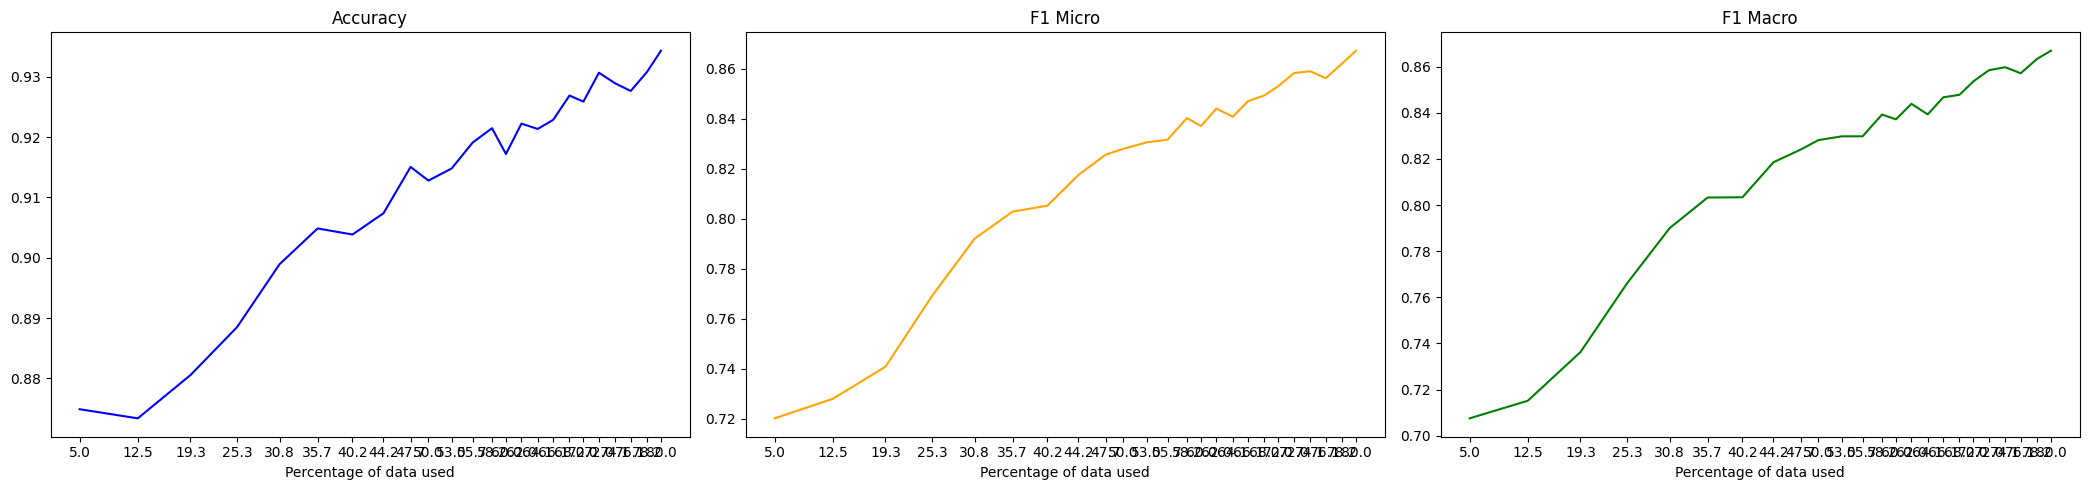

In [25]:
active_learning(42, 0, 'coreset')

# RANDOM SAMPLING

TRIAL 1
Random seed: 42
Launching training on 2 GPUs.
DistributedType.MULTI_GPU


pytorch_model.bin:   0%|          | 0.00/498M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5825, Accuracy: 0.7519, F1 Micro: 0.0, F1 Macro: 0.0
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.5327, Accuracy: 0.7824, F1 Micro: 0.2355, F1 Macro: 0.1698
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.4418, Accuracy: 0.8053, F1 Micro: 0.4476, F1 Macro: 0.3799
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3815, Accuracy: 0.8144, F1 Micro: 0.5244, F1 Macro: 0.4272
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.3367, Accuracy: 0.825, F1 Micro: 0.5402, F1 Macro: 0.439
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.3027, Accuracy: 0.8426, F1 Micro: 0.6165, F1 Macro: 0.5579
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.2606, Accuracy: 0.8581, F1 Micro: 0.6627, F1 Macro: 0.6291
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.2308, Accuracy: 0.864, F1 Micro: 0.7094, F1 Macro: 0.7011
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1803, 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5468, Accuracy: 0.7688, F1 Micro: 0.1461, F1 Macro: 0.139
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4186, Accuracy: 0.827, F1 Micro: 0.5532, F1 Macro: 0.4747
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3335, Accuracy: 0.8671, F1 Micro: 0.7199, F1 Macro: 0.7098
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2748, Accuracy: 0.8787, F1 Micro: 0.7226, F1 Macro: 0.6974
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2082, Accuracy: 0.8918, F1 Micro: 0.7761, F1 Macro: 0.7751
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1669, Accuracy: 0.8911, F1 Micro: 0.7878, F1 Macro: 0.7918
Epoch 7/10, Train Loss: 0.1327, Accuracy: 0.8936, F1 Micro: 0.785, F1 Macro: 0.7856
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1062, Accuracy: 0.8947, F1 Micro: 0.7904, F1 Macro: 0.7921
Epoch 9/10, Train Loss: 0.0741, Accuracy: 0.8919, F1 Micro: 0.7712, F1 Macro: 0.7659
Epoch 1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5162, Accuracy: 0.811, F1 Micro: 0.5347, F1 Macro: 0.4593
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3557, Accuracy: 0.865, F1 Micro: 0.7057, F1 Macro: 0.6901
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2738, Accuracy: 0.8886, F1 Micro: 0.7551, F1 Macro: 0.7474
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.219, Accuracy: 0.8958, F1 Micro: 0.7856, F1 Macro: 0.7863
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1704, Accuracy: 0.9011, F1 Micro: 0.8042, F1 Macro: 0.8067
Epoch 6/10, Train Loss: 0.1321, Accuracy: 0.8988, F1 Micro: 0.7956, F1 Macro: 0.796
Epoch 7/10, Train Loss: 0.0852, Accuracy: 0.8987, F1 Micro: 0.7972, F1 Macro: 0.7984
Epoch 8/10, Train Loss: 0.0637, Accuracy: 0.8993, F1 Micro: 0.7912, F1 Macro: 0.7901
Epoch 9/10, Train Loss: 0.0493, Accuracy: 0.9013, F1 Micro: 0.7995, F1 Macro: 0.7977
Epoch 10/10, Train Loss: 0.0385, Accuracy: 0.9021, F1 Micro: 0.7978, F1 Ma

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4867, Accuracy: 0.8228, F1 Micro: 0.5132, F1 Macro: 0.3967
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.317, Accuracy: 0.8769, F1 Micro: 0.7269, F1 Macro: 0.7089
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2514, Accuracy: 0.8991, F1 Micro: 0.7996, F1 Macro: 0.8015
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1912, Accuracy: 0.9036, F1 Micro: 0.8004, F1 Macro: 0.7971
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1454, Accuracy: 0.9089, F1 Micro: 0.8105, F1 Macro: 0.8086
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1032, Accuracy: 0.9112, F1 Micro: 0.8176, F1 Macro: 0.8152
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0777, Accuracy: 0.9081, F1 Micro: 0.8192, F1 Macro: 0.822
Epoch 8/10, Train Loss: 0.0591, Accuracy: 0.9065, F1 Micro: 0.8067, F1 Macro: 0.8039
Epoch 9/10, Train Loss: 0.0415, Accuracy: 0.9104, F1 Micro: 0.817, F1 Macro: 0.8158
Higher 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4527, Accuracy: 0.8514, F1 Micro: 0.6527, F1 Macro: 0.6157
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2883, Accuracy: 0.8953, F1 Micro: 0.7838, F1 Macro: 0.782
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2284, Accuracy: 0.9028, F1 Micro: 0.8071, F1 Macro: 0.8083
Epoch 4/10, Train Loss: 0.1723, Accuracy: 0.9088, F1 Micro: 0.807, F1 Macro: 0.802
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1246, Accuracy: 0.9137, F1 Micro: 0.8188, F1 Macro: 0.8175
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0943, Accuracy: 0.9127, F1 Micro: 0.8238, F1 Macro: 0.8228
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0619, Accuracy: 0.9144, F1 Micro: 0.8244, F1 Macro: 0.8234
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0418, Accuracy: 0.9165, F1 Micro: 0.8275, F1 Macro: 0.8258
Epoch 9/10, Train Loss: 0.0361, Accuracy: 0.9078, F1 Micro: 0.8198, F1 Macro: 0.8202
Epoch 1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4423, Accuracy: 0.8531, F1 Micro: 0.6507, F1 Macro: 0.6035
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2719, Accuracy: 0.8964, F1 Micro: 0.7938, F1 Macro: 0.7962
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1969, Accuracy: 0.9068, F1 Micro: 0.8017, F1 Macro: 0.7958
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1564, Accuracy: 0.9127, F1 Micro: 0.8152, F1 Macro: 0.8135
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.118, Accuracy: 0.9095, F1 Micro: 0.8172, F1 Macro: 0.8161
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0803, Accuracy: 0.9104, F1 Micro: 0.8255, F1 Macro: 0.8266
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0551, Accuracy: 0.9168, F1 Micro: 0.8259, F1 Macro: 0.8236
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.042, Accuracy: 0.9099, F1 Micro: 0.8276, F1 Macro: 0.8299
Epoch 9/10, Train Loss: 0.0324, Accuracy: 0.9113, F1 Micro

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4334, Accuracy: 0.8775, F1 Micro: 0.7318, F1 Macro: 0.7215
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.256, Accuracy: 0.9028, F1 Micro: 0.794, F1 Macro: 0.7902
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1917, Accuracy: 0.911, F1 Micro: 0.8128, F1 Macro: 0.809
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1559, Accuracy: 0.9157, F1 Micro: 0.8271, F1 Macro: 0.8231
Epoch 5/10, Train Loss: 0.1084, Accuracy: 0.9166, F1 Micro: 0.8265, F1 Macro: 0.8266
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0733, Accuracy: 0.9167, F1 Micro: 0.8328, F1 Macro: 0.8338
Epoch 7/10, Train Loss: 0.056, Accuracy: 0.92, F1 Micro: 0.8289, F1 Macro: 0.8254
Epoch 8/10, Train Loss: 0.0377, Accuracy: 0.9151, F1 Micro: 0.823, F1 Macro: 0.8188
Epoch 9/10, Train Loss: 0.0308, Accuracy: 0.9149, F1 Micro: 0.8228, F1 Macro: 0.8155
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.0235, Accuracy: 0.

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4201, Accuracy: 0.8828, F1 Micro: 0.7451, F1 Macro: 0.7425
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.251, Accuracy: 0.9025, F1 Micro: 0.8015, F1 Macro: 0.7985
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1819, Accuracy: 0.9158, F1 Micro: 0.8242, F1 Macro: 0.8226
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1402, Accuracy: 0.9182, F1 Micro: 0.8329, F1 Macro: 0.8285
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.097, Accuracy: 0.9194, F1 Micro: 0.8368, F1 Macro: 0.8362
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0714, Accuracy: 0.9171, F1 Micro: 0.8371, F1 Macro: 0.8388
Epoch 7/10, Train Loss: 0.0499, Accuracy: 0.9172, F1 Micro: 0.8215, F1 Macro: 0.8175
Epoch 8/10, Train Loss: 0.0332, Accuracy: 0.9185, F1 Micro: 0.8349, F1 Macro: 0.8337
Epoch 9/10, Train Loss: 0.0307, Accuracy: 0.9187, F1 Micro: 0.8346, F1 Macro: 0.8341
Epoch 10/10, Train Loss: 0.0263, Accura

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4129, Accuracy: 0.8836, F1 Micro: 0.7667, F1 Macro: 0.7624
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2447, Accuracy: 0.9078, F1 Micro: 0.8073, F1 Macro: 0.8048
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1791, Accuracy: 0.9171, F1 Micro: 0.8214, F1 Macro: 0.818
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1403, Accuracy: 0.9154, F1 Micro: 0.8317, F1 Macro: 0.8322
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.0974, Accuracy: 0.9214, F1 Micro: 0.8407, F1 Macro: 0.8407
Epoch 6/10, Train Loss: 0.0663, Accuracy: 0.9199, F1 Micro: 0.8387, F1 Macro: 0.8385
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0498, Accuracy: 0.9215, F1 Micro: 0.8434, F1 Macro: 0.8437
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0356, Accuracy: 0.9229, F1 Micro: 0.8436, F1 Macro: 0.8414
Epoch 9/10, Train Loss: 0.0275, Accuracy: 0.921, F1 Micro: 0.8341, F1 Macro: 0.8301
Higher

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4011, Accuracy: 0.8776, F1 Micro: 0.7355, F1 Macro: 0.7234
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2437, Accuracy: 0.9064, F1 Micro: 0.8108, F1 Macro: 0.8126
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1838, Accuracy: 0.9041, F1 Micro: 0.8215, F1 Macro: 0.8247
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.136, Accuracy: 0.9189, F1 Micro: 0.8379, F1 Macro: 0.8372
Epoch 5/10, Train Loss: 0.0959, Accuracy: 0.9154, F1 Micro: 0.8365, F1 Macro: 0.8373
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0675, Accuracy: 0.9231, F1 Micro: 0.8441, F1 Macro: 0.8435
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0495, Accuracy: 0.9244, F1 Micro: 0.8482, F1 Macro: 0.8477
Epoch 8/10, Train Loss: 0.032, Accuracy: 0.9209, F1 Micro: 0.8388, F1 Macro: 0.8373
Epoch 9/10, Train Loss: 0.0277, Accuracy: 0.9235, F1 Micro: 0.8463, F1 Macro: 0.8458
Epoch 10/10, Train Loss: 0.0191, Accura

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3937, Accuracy: 0.8914, F1 Micro: 0.78, F1 Macro: 0.7813
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2357, Accuracy: 0.9031, F1 Micro: 0.8122, F1 Macro: 0.8143
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1781, Accuracy: 0.9176, F1 Micro: 0.8307, F1 Macro: 0.8286
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.125, Accuracy: 0.9211, F1 Micro: 0.8347, F1 Macro: 0.833
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.0934, Accuracy: 0.9228, F1 Micro: 0.8421, F1 Macro: 0.8408
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0647, Accuracy: 0.9239, F1 Micro: 0.8447, F1 Macro: 0.8432
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0447, Accuracy: 0.926, F1 Micro: 0.8524, F1 Macro: 0.8532
Epoch 8/10, Train Loss: 0.0318, Accuracy: 0.9217, F1 Micro: 0.8441, F1 Macro: 0.8438
Epoch 9/10, Train Loss: 0.0234, Accuracy: 0.9235, F1 Micro: 0.8488, F1 Macro: 0.8492
Higher F1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3944, Accuracy: 0.8894, F1 Micro: 0.7674, F1 Macro: 0.7654
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.235, Accuracy: 0.9108, F1 Micro: 0.8125, F1 Macro: 0.8099
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1762, Accuracy: 0.9163, F1 Micro: 0.8274, F1 Macro: 0.8238
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1276, Accuracy: 0.9162, F1 Micro: 0.8406, F1 Macro: 0.8424
Epoch 5/10, Train Loss: 0.0923, Accuracy: 0.917, F1 Micro: 0.8401, F1 Macro: 0.8439
Epoch 6/10, Train Loss: 0.0644, Accuracy: 0.9221, F1 Micro: 0.8348, F1 Macro: 0.8304
Epoch 7/10, Train Loss: 0.0448, Accuracy: 0.9209, F1 Micro: 0.8406, F1 Macro: 0.839
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0354, Accuracy: 0.9231, F1 Micro: 0.8464, F1 Macro: 0.845
Epoch 9/10, Train Loss: 0.0243, Accuracy: 0.9221, F1 Micro: 0.8396, F1 Macro: 0.8381
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.0205, Accuracy

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3774, Accuracy: 0.8842, F1 Micro: 0.7431, F1 Macro: 0.727
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2354, Accuracy: 0.9114, F1 Micro: 0.8169, F1 Macro: 0.815
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1745, Accuracy: 0.9226, F1 Micro: 0.842, F1 Macro: 0.8412
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1271, Accuracy: 0.9235, F1 Micro: 0.8468, F1 Macro: 0.8456
Epoch 5/10, Train Loss: 0.0885, Accuracy: 0.9209, F1 Micro: 0.8386, F1 Macro: 0.8361
Epoch 6/10, Train Loss: 0.0589, Accuracy: 0.9223, F1 Micro: 0.8409, F1 Macro: 0.8387
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.042, Accuracy: 0.923, F1 Micro: 0.8477, F1 Macro: 0.8479
Epoch 8/10, Train Loss: 0.0303, Accuracy: 0.9236, F1 Micro: 0.8457, F1 Macro: 0.8461
Epoch 9/10, Train Loss: 0.0253, Accuracy: 0.921, F1 Micro: 0.8359, F1 Macro: 0.8309
Epoch 10/10, Train Loss: 0.0228, Accuracy: 0.9224, F1 Micro: 0.8398, F1 Macr

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3861, Accuracy: 0.8908, F1 Micro: 0.7638, F1 Macro: 0.7597
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2364, Accuracy: 0.9062, F1 Micro: 0.812, F1 Macro: 0.8103
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1761, Accuracy: 0.92, F1 Micro: 0.8399, F1 Macro: 0.8387
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1277, Accuracy: 0.9192, F1 Micro: 0.8418, F1 Macro: 0.8427
Epoch 5/10, Train Loss: 0.0926, Accuracy: 0.9217, F1 Micro: 0.8411, F1 Macro: 0.839
Epoch 6/10, Train Loss: 0.0615, Accuracy: 0.9219, F1 Micro: 0.8388, F1 Macro: 0.8359
Epoch 7/10, Train Loss: 0.048, Accuracy: 0.9195, F1 Micro: 0.83, F1 Macro: 0.8248
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0301, Accuracy: 0.9236, F1 Micro: 0.8477, F1 Macro: 0.847
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0242, Accuracy: 0.9253, F1 Micro: 0.8486, F1 Macro: 0.8474
Epoch 10/10, Train Loss: 0.0184, Accuracy: 0.

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3813, Accuracy: 0.8812, F1 Micro: 0.7296, F1 Macro: 0.7115
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.233, Accuracy: 0.9105, F1 Micro: 0.8182, F1 Macro: 0.8157
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1728, Accuracy: 0.9181, F1 Micro: 0.8391, F1 Macro: 0.8406
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1298, Accuracy: 0.9194, F1 Micro: 0.8433, F1 Macro: 0.8454
Epoch 5/10, Train Loss: 0.088, Accuracy: 0.921, F1 Micro: 0.8321, F1 Macro: 0.8293
Epoch 6/10, Train Loss: 0.0611, Accuracy: 0.923, F1 Micro: 0.843, F1 Macro: 0.8418
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0445, Accuracy: 0.9226, F1 Micro: 0.8469, F1 Macro: 0.8466
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0337, Accuracy: 0.9259, F1 Micro: 0.8472, F1 Macro: 0.8435
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0264, Accuracy: 0.925, F1 Micro: 0.8476, F1 Macro: 0.8463
Epoch 10/1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3814, Accuracy: 0.8873, F1 Micro: 0.7847, F1 Macro: 0.7906
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2316, Accuracy: 0.9147, F1 Micro: 0.8225, F1 Macro: 0.8199
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1667, Accuracy: 0.9175, F1 Micro: 0.8408, F1 Macro: 0.8412
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1206, Accuracy: 0.9263, F1 Micro: 0.8482, F1 Macro: 0.8462
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.0897, Accuracy: 0.924, F1 Micro: 0.8496, F1 Macro: 0.8485
Epoch 6/10, Train Loss: 0.063, Accuracy: 0.9199, F1 Micro: 0.847, F1 Macro: 0.8482
Epoch 7/10, Train Loss: 0.0454, Accuracy: 0.9234, F1 Micro: 0.8453, F1 Macro: 0.845
Epoch 8/10, Train Loss: 0.0324, Accuracy: 0.9205, F1 Micro: 0.8402, F1 Macro: 0.8399
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0295, Accuracy: 0.9262, F1 Micro: 0.8496, F1 Macro: 0.8499
Epoch 10/10, Train Loss: 0.0202, Accuracy

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3748, Accuracy: 0.8923, F1 Micro: 0.7652, F1 Macro: 0.7581
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2201, Accuracy: 0.9124, F1 Micro: 0.8283, F1 Macro: 0.8288
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1681, Accuracy: 0.9231, F1 Micro: 0.8454, F1 Macro: 0.8458
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1175, Accuracy: 0.9244, F1 Micro: 0.8518, F1 Macro: 0.8533
Epoch 5/10, Train Loss: 0.0807, Accuracy: 0.9231, F1 Micro: 0.8453, F1 Macro: 0.8454
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0593, Accuracy: 0.9259, F1 Micro: 0.853, F1 Macro: 0.8534
Epoch 7/10, Train Loss: 0.0413, Accuracy: 0.9225, F1 Micro: 0.8516, F1 Macro: 0.8524
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0328, Accuracy: 0.9279, F1 Micro: 0.8575, F1 Macro: 0.8574
Epoch 9/10, Train Loss: 0.0241, Accuracy: 0.9248, F1 Micro: 0.845, F1 Macro: 0.8431
Epoch 10/10, Train Loss: 0.0206, Accura

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3778, Accuracy: 0.8938, F1 Micro: 0.7878, F1 Macro: 0.7882
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2217, Accuracy: 0.9146, F1 Micro: 0.8308, F1 Macro: 0.8316
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.161, Accuracy: 0.9225, F1 Micro: 0.8383, F1 Macro: 0.8348
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1205, Accuracy: 0.9255, F1 Micro: 0.8434, F1 Macro: 0.8416
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.0853, Accuracy: 0.9296, F1 Micro: 0.8573, F1 Macro: 0.8571
Epoch 6/10, Train Loss: 0.0544, Accuracy: 0.9253, F1 Micro: 0.8564, F1 Macro: 0.8579
Epoch 7/10, Train Loss: 0.0408, Accuracy: 0.9243, F1 Micro: 0.8516, F1 Macro: 0.8527
Epoch 8/10, Train Loss: 0.0333, Accuracy: 0.9287, F1 Micro: 0.8564, F1 Macro: 0.8559
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0243, Accuracy: 0.9323, F1 Micro: 0.8642, F1 Macro: 0.8641
Epoch 10/10, Train Loss: 0.0221, Accur

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3677, Accuracy: 0.896, F1 Micro: 0.7891, F1 Macro: 0.7897
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2172, Accuracy: 0.9156, F1 Micro: 0.8299, F1 Macro: 0.8314
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1698, Accuracy: 0.9165, F1 Micro: 0.8365, F1 Macro: 0.8357
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1195, Accuracy: 0.9217, F1 Micro: 0.8429, F1 Macro: 0.8447
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.0766, Accuracy: 0.9287, F1 Micro: 0.8521, F1 Macro: 0.8502
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0554, Accuracy: 0.924, F1 Micro: 0.8535, F1 Macro: 0.8552
Epoch 7/10, Train Loss: 0.0401, Accuracy: 0.9221, F1 Micro: 0.8504, F1 Macro: 0.8521
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.03, Accuracy: 0.9277, F1 Micro: 0.8564, F1 Macro: 0.8573
Epoch 9/10, Train Loss: 0.0224, Accuracy: 0.9294, F1 Micro: 0.8555, F1 Macro: 0.8549
Epoch 10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3641, Accuracy: 0.8973, F1 Micro: 0.7816, F1 Macro: 0.7766
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2142, Accuracy: 0.9166, F1 Micro: 0.8305, F1 Macro: 0.8305
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1643, Accuracy: 0.9216, F1 Micro: 0.846, F1 Macro: 0.8475
Epoch 4/10, Train Loss: 0.1144, Accuracy: 0.926, F1 Micro: 0.8453, F1 Macro: 0.8435
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.082, Accuracy: 0.9267, F1 Micro: 0.8495, F1 Macro: 0.8473
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0539, Accuracy: 0.927, F1 Micro: 0.8499, F1 Macro: 0.8488
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0371, Accuracy: 0.9268, F1 Micro: 0.8538, F1 Macro: 0.8549
Epoch 8/10, Train Loss: 0.0275, Accuracy: 0.9215, F1 Micro: 0.8495, F1 Macro: 0.8508
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0241, Accuracy: 0.9297, F1 Micro: 0.8584, F1 Macro: 0.8589
Epoch 10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3568, Accuracy: 0.8978, F1 Micro: 0.7734, F1 Macro: 0.7661
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2173, Accuracy: 0.9167, F1 Micro: 0.8355, F1 Macro: 0.8363
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1607, Accuracy: 0.9268, F1 Micro: 0.8497, F1 Macro: 0.8496
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1115, Accuracy: 0.9254, F1 Micro: 0.8499, F1 Macro: 0.8485
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.084, Accuracy: 0.9244, F1 Micro: 0.8503, F1 Macro: 0.8521
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0543, Accuracy: 0.9264, F1 Micro: 0.8521, F1 Macro: 0.8515
Epoch 7/10, Train Loss: 0.042, Accuracy: 0.9219, F1 Micro: 0.8363, F1 Macro: 0.8327
Epoch 8/10, Train Loss: 0.0338, Accuracy: 0.9236, F1 Micro: 0.8482, F1 Macro: 0.8468
Epoch 9/10, Train Loss: 0.0239, Accuracy: 0.9252, F1 Micro: 0.8506, F1 Macro: 0.8512
Higher F1 achieved, saving model
Epoch 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3636, Accuracy: 0.8959, F1 Micro: 0.7753, F1 Macro: 0.7677
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.213, Accuracy: 0.9144, F1 Micro: 0.8312, F1 Macro: 0.833
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1618, Accuracy: 0.9239, F1 Micro: 0.8419, F1 Macro: 0.8382
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1174, Accuracy: 0.9286, F1 Micro: 0.8575, F1 Macro: 0.8569
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.0832, Accuracy: 0.9301, F1 Micro: 0.861, F1 Macro: 0.8613
Epoch 6/10, Train Loss: 0.0602, Accuracy: 0.9283, F1 Micro: 0.8587, F1 Macro: 0.8589
Epoch 7/10, Train Loss: 0.0398, Accuracy: 0.928, F1 Micro: 0.8555, F1 Macro: 0.8547
Epoch 8/10, Train Loss: 0.029, Accuracy: 0.9284, F1 Micro: 0.8579, F1 Macro: 0.8586
Epoch 9/10, Train Loss: 0.0236, Accuracy: 0.9298, F1 Micro: 0.8589, F1 Macro: 0.8598
Epoch 10/10, Train Loss: 0.0177, Accuracy: 0.9272, F1 Micro: 0.8502, F1 Mac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3577, Accuracy: 0.9028, F1 Micro: 0.7936, F1 Macro: 0.7906
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2106, Accuracy: 0.9103, F1 Micro: 0.8278, F1 Macro: 0.8294
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1583, Accuracy: 0.9209, F1 Micro: 0.8355, F1 Macro: 0.831
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1165, Accuracy: 0.9199, F1 Micro: 0.8455, F1 Macro: 0.849
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.0798, Accuracy: 0.9282, F1 Micro: 0.8518, F1 Macro: 0.8514
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0532, Accuracy: 0.9291, F1 Micro: 0.8551, F1 Macro: 0.8526
Epoch 7/10, Train Loss: 0.036, Accuracy: 0.9257, F1 Micro: 0.8443, F1 Macro: 0.841
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0278, Accuracy: 0.927, F1 Micro: 0.8563, F1 Macro: 0.8569
Epoch 9/10, Train Loss: 0.0233, Accuracy: 0.927, F1 Micro: 0.8561, F1 Macro: 0.8552
Higher F1 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3509, Accuracy: 0.8979, F1 Micro: 0.7805, F1 Macro: 0.7769
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2136, Accuracy: 0.9177, F1 Micro: 0.8314, F1 Macro: 0.8325
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1586, Accuracy: 0.9278, F1 Micro: 0.8553, F1 Macro: 0.8544
Epoch 4/10, Train Loss: 0.1172, Accuracy: 0.927, F1 Micro: 0.8552, F1 Macro: 0.8544
Epoch 5/10, Train Loss: 0.0795, Accuracy: 0.9253, F1 Micro: 0.8545, F1 Macro: 0.8556
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0571, Accuracy: 0.9293, F1 Micro: 0.8582, F1 Macro: 0.8584
Epoch 7/10, Train Loss: 0.0369, Accuracy: 0.9268, F1 Micro: 0.8517, F1 Macro: 0.8515
Epoch 8/10, Train Loss: 0.0264, Accuracy: 0.9288, F1 Micro: 0.855, F1 Macro: 0.8554
Epoch 9/10, Train Loss: 0.0245, Accuracy: 0.9277, F1 Micro: 0.8495, F1 Macro: 0.8469
Epoch 10/10, Train Loss: 0.0197, Accuracy: 0.9289, F1 Micro: 0.8566, F1 Macro: 0.8564

 Iteration 7840: A

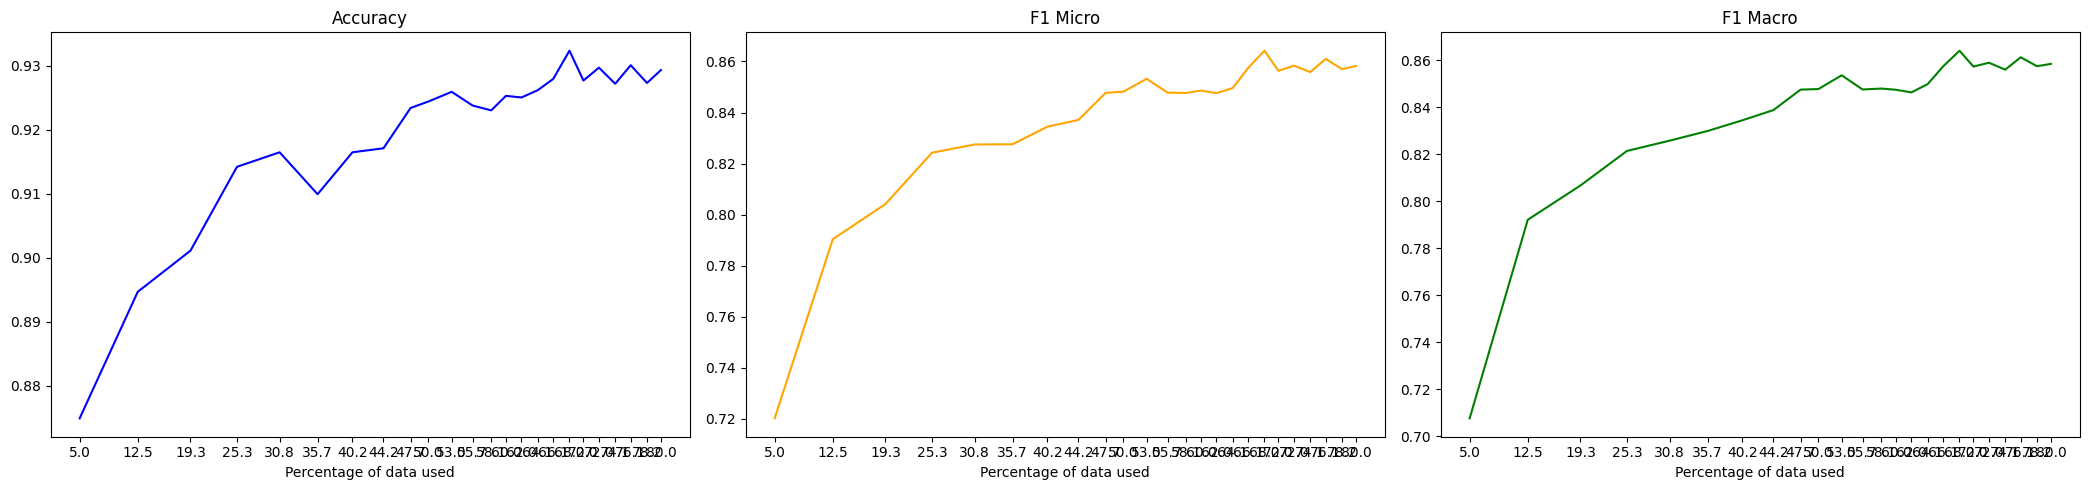

In [ ]:
active_learning(42, 0, 'random')